In [1]:
# 라이브러리 import 및 설정

import pandas as pd
import numpy as np
import pyodbc
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import optuna
import json
from datetime import datetime

# matplotlib을 위한 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 import 완료")

라이브러리 import 완료


In [2]:
# DB 연결 및 데이터 로드

# 데이터베이스 설정
DB_CONFIG = {
    'driver': 'ODBC Driver 17 for SQL Server',
    'server': 'localhost',
    'database': 'real_data',
    'trusted_connection': 'yes'
}

# DB 연결
conn_str = (
    f"DRIVER={{{DB_CONFIG['driver']}}};"
    f"SERVER={DB_CONFIG['server']};"
    f"DATABASE={DB_CONFIG['database']};"
    f"Trusted_Connection={DB_CONFIG['trusted_connection']};"
)

conn = pyodbc.connect(conn_str)

query = "SELECT * FROM union_charge_divided_by_pattern"
df = pd.read_sql(query, conn)
conn.close()

print(f"데이터 로드 완료: {df.shape}")
print(f"\n컬럼 목록:")
print(df.columns.tolist())
df.head()

데이터 로드 완료: (8950, 91)

컬럼 목록:
['time', 'charge', 'charge_min', 'melting_min', 'oxidation_min', 'work_time', 'EAF_wattage', 'CaO_CFW', 'Dolomite_CFW', 'CaO_HP', 'FeMn_HP', 'FeSi_HP', 'SiMn_HP', 'Briquette_HP1', 'Briquette_HP2', 'melting_wattage', 'refining_wattage', 'wattage', 'lng_usage', 'coal_gsk', 'coal_stain', 'small_lump', 'Weight_Sum', 'tot_result1', 'consume_rate', 'tot_result4', 'scrap_domestic', 'scrap_iron_powder', 'scrap_heavy_a', 'scrap_heavy_b', 'scrap_container', 'scrap_h1', 'scrap_h2', 'scrap_russia', 'scrap_gs', 'master_speed_p3', 'master_location_p3', 'len_flow_p3', 'oxygen_bu_p3', 'oxygen_len_p3', 'master_speed_p5', 'master_location_p5', 'len_flow_p5', 'oxygen_bu_p5', 'oxygen_len_p5', 'master_speed_p8', 'master_location_p8', 'len_flow_p8', 'oxygen_bu_p8', 'oxygen_len_p8', 'scrap_bal_go', 'len_tilting_height_p3', 'len_tilting_width_p3', 'len_tilting_height_p5', 'len_tilting_width_p5', 'len_tilting_height_p8', 'len_tilting_width_p8', 'power_factor_p3', 'set_voltage_p3',

,time,charge,charge_min,melting_min,oxidation_min,work_time,EAF_wattage,CaO_CFW,Dolomite_CFW,CaO_HP,...,precipitator_wind_p5,precipitator_jig_p8,precipitator_gun_p8,precipitator_wind_p8,coal_stain_p3,coal_stain_p5,coal_stain_p8,coal_gsk_p3,coal_gsk_p5,coal_gsk_p8
0,2022-01-02,2200008,2.0,30.0,5.0,43.0,8800.0,NaN,NaN,595.0,...,106811.97,596.57,1859.70,104319.60,0.0,231.0,448.0,0.0,138.0,272.0
1,2022-01-03,2200031,2.0,30.0,6.0,44.0,29900.0,NaN,NaN,597.0,...,99562.53,550.80,1953.49,102490.38,0.0,120.0,165.0,0.0,190.0,191.0
2,2022-01-03,2200036,2.0,30.0,5.0,43.0,25900.0,NaN,NaN,593.0,...,99884.62,582.13,1862.99,103613.78,0.0,96.0,222.0,0.0,120.0,277.0
3,2022-01-04,2200074,2.0,28.0,12.0,48.0,35800.0,NaN,NaN,598.0,...,97155.71,635.90,1863.52,100912.30,0.0,120.0,367.0,11.0,76.0,325.0
4,2022-01-06,2200097,2.0,30.0,8.0,46.0,18100.0,NaN,NaN,596.0,...,107286.12,516.42,1768.69,107425.97,0.0,181.0,331.0,26.0,194.0,165.0


In [3]:
# time 컬럼 제거 (학습에 사용 안 함)
if 'time' in df.columns:
    df_processed = df.drop('time', axis=1)
else:
    df_processed = df.copy()

# 결측치(미투입)를 0으로 변환
df_processed = df_processed.fillna(0)

print(f"전처리 전: {df.shape}")
print(f"전처리 후: {df_processed.shape}")

# 결측치 현황 확인
null_counts = df_processed.isnull().sum().sort_values(ascending=False)
print(f"\n결측치 개수: {null_counts.sum()} (전부 0으로 채움 완료)")

전처리 전: (8950, 91)
전처리 후: (8950, 90)

결측치 개수: 0 (전부 0으로 채움 완료)


In [4]:
# 예측할 목표 변수 선택
TARGETS = ['refining_wattage']

# 사용할 특성만 직접 선택
SELECTED_FEATURES = [
    #시간
    #'time',
    # 'charge',
    # 'charge_min',
    # 'melting_min',
    # 'oxidation_min',
    # 'work_time',
    
    
    #부원료
    # 'CaO_CFW',
    # 'Dolomite_CFW',
    'CaO_HP',
    'FeMn_HP',
    'FeSi_HP',
    'SiMn_HP',
    'Briquette_HP1',
    'Briquette_HP2',
    'precipitator_jig_p3',
    'precipitator_jig_p5',
    'precipitator_jig_p8',
    'precipitator_gun_p3',
    'precipitator_gun_p5',
    'precipitator_gun_p8',
    'precipitator_wind_p3',
    'precipitator_wind_p5',
    'precipitator_wind_p8',



    #전력량
    #'melting_wattage',
    #'refining_wattage',
    #'wattage_tmp',
    # 'EAF_wattage',

    #마스터
    # 'master_speed_p3',
    'master_location_p3',
    # 'master_speed_p5',
    'master_location_p5',
    # 'master_speed_p8',
    'master_location_p8',

    #랜스
    # 'len_tilting_height',
    # 'len_tilting_width',
    # 'len_flow_p3',
    # 'len_flow_p5',
    # 'len_flow_p8',
    'oxygen_len_p3',
    'oxygen_len_p5',
    'oxygen_len_p8',
    'len_tilting_height_p3',
    'len_tilting_width_p3',
    'len_tilting_height_p5',
    'len_tilting_width_p5',
    'len_tilting_height_p8',
    'len_tilting_width_p8',

    #버너
    'oxygen_bu_p3',
    'oxygen_bu_p5',
    'oxygen_bu_p8',
    
    #스크랩
    'Weight_Sum',
    # 'tot_result1',
    # 'tot_result4',
    'scrap_bal_go',
    'scrap_container',
    'scrap_domestic',
    'scrap_gs',
    'scrap_h1',
    'scrap_h2',
    'scrap_heavy_a',
    'scrap_heavy_b',
    'scrap_russia',

    'lng_usage',
    'coal_gsk',
    'coal_stain',
    'small_lump',
    # 'power_factor',
    # 'real_voltage',
    # 'real_current',

    'coal_gsk_p3',
    'coal_gsk_p5',
    'coal_gsk_p8',
    'coal_stain_p3',
    'coal_stain_p5',
    'coal_stain_p8'

    
    ]


#target들 중 하나라도 null인 행 제거
df_model = df_processed.dropna(subset=TARGETS)


# X, y 분리
X = df_model[SELECTED_FEATURES]
y = df_model[TARGETS]

print("=" * 60)
print(f"타겟 변수: {TARGETS}")
print(f"데이터 개수: {len(X)}")
print(f"사용할 특성 개수: {len(SELECTED_FEATURES)}")
print("=" * 60)


print(f"\n【타겟 변수 통계】")
if len(TARGETS) == 1:
    print(y.describe())
else:
    print(y.describe())

print(f"\n【사용할 특성 ({len(SELECTED_FEATURES)}개)】")
for i, feat in enumerate(SELECTED_FEATURES, 1):
    null_count = X[feat].isnull().sum()
    null_pct = (null_count / len(X)) * 100
    print(f"{i:2d}. {feat:25s} (결측: {null_count:4d}건, {null_pct:5.1f}%)")

타겟 변수: ['refining_wattage']
데이터 개수: 8950
사용할 특성 개수: 50

【타겟 변수 통계】
       refining_wattage
count       8950.000000
mean        9025.832402
std         1465.742741
min         4600.000000
25%         8000.000000
50%         9100.000000
75%        10000.000000
max        13600.000000

【사용할 특성 (50개)】
 1. CaO_HP                    (결측:    0건,   0.0%)
 2. FeMn_HP                   (결측:    0건,   0.0%)
 3. FeSi_HP                   (결측:    0건,   0.0%)
 4. SiMn_HP                   (결측:    0건,   0.0%)
 5. Briquette_HP1             (결측:    0건,   0.0%)
 6. Briquette_HP2             (결측:    0건,   0.0%)
 7. precipitator_jig_p3       (결측:    0건,   0.0%)
 8. precipitator_jig_p5       (결측:    0건,   0.0%)
 9. precipitator_jig_p8       (결측:    0건,   0.0%)
10. precipitator_gun_p3       (결측:    0건,   0.0%)
11. precipitator_gun_p5       (결측:    0건,   0.0%)
12. precipitator_gun_p8       (결측:    0건,   0.0%)
13. precipitator_wind_p3      (결측:    0건,   0.0%)
14. precipitator_wind_p5      (결측:    0건,   0.0%)
1

In [5]:
import numpy as np
import pandas as pd
import pyodbc

DB_CONFIG = {
    "driver": "ODBC Driver 17 for SQL Server",
    "server": "localhost",
    "database": "real_data",
    "trusted_connection": "yes",
}

conn_str = (
    f"DRIVER={{{DB_CONFIG['driver']}}};"
    f"SERVER={DB_CONFIG['server']};"
    f"DATABASE={DB_CONFIG['database']};"
    f"Trusted_Connection={DB_CONFIG['trusted_connection']};"
    "TrustServerCertificate=yes;"
)

conn = pyodbc.connect(conn_str)
df = pd.read_sql(
    "SELECT Weight_Sum, precipitator_gun_p8,wattage_tmp FROM union_charge_divided_by_pattern",
    conn
)
conn.close()

def calc_stats(series):
    s = series.dropna().to_numpy()
    if len(s) == 0:
        return None
    uniq = np.unique(s)
    step = None
    if len(uniq) >= 3:
        diffs = np.diff(np.sort(uniq))
        diffs = diffs[diffs > 0]
        step = float(np.min(diffs)) if len(diffs) else None
    return {
        "min": float(np.min(s)),
        "max": float(np.max(s)),
        "step": step,
        "mean": float(np.mean(s)),
        "median": float(np.median(s)),
    }

result = [
    {"key": "Weight_Sum", **calc_stats(df["Weight_Sum"])},
    {"key": "precipitator_gun_p8", **calc_stats(df["precipitator_gun_p8"])},
    {"key": "wattage_tmp", **calc_stats(df["wattage_tmp"])},
]

result


[{'key': 'Weight_Sum',
  'min': 109.05,
  'max': 127.0,
  'step': 0.009999999999990905,
  'mean': 121.11679888268158,
  'median': 121.25},
 {'key': 'precipitator_gun_p8',
  'min': 1080.7,
  'max': 2342.46,
  'step': 0.009999999999763531,
  'mean': 1932.4161452513968,
  'median': 1952.18},
 {'key': 'wattage_tmp',
  'min': 40800.0,
  'max': 53000.0,
  'step': 100.0,
  'mean': 44923.262569832405,
  'median': 44900.0}]

In [6]:
# 데이터 분할 (학습, 테스트 각각 0.8, 0.2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
    
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain y 데이터 통계:")
print(y_train.describe())
print(f"\nTest y 데이터 통계:")
print(y_test.describe())

Train set: (7160, 50)
Test set: (1790, 50)

Train y 데이터 통계:
       refining_wattage
count       7160.000000
mean        9015.167598
std         1471.728869
min         4600.000000
25%         7900.000000
50%         9100.000000
75%        10000.000000
max        13600.000000

Test y 데이터 통계:
       refining_wattage
count       1790.000000
mean        9068.491620
std         1441.166483
min         4600.000000
25%         8000.000000
50%         9200.000000
75%        10000.000000
max        13500.000000


n=2  BIC: 645641.1  AIC: 644258.9
n=3  BIC: 591832.5  AIC: 589755.8
n=4  BIC: 530187.4  AIC: 527416.3

Best n by BIC: 4
Best n by AIC: 4


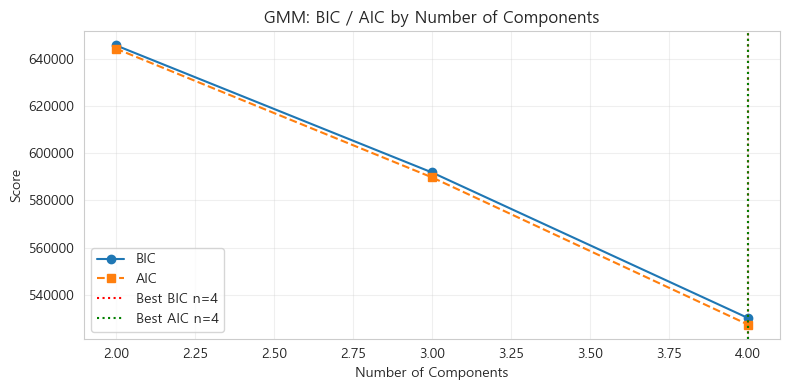

In [7]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- globals 초기화 ---
if "X_train" not in globals():
    X_train = X_test = y_train = y_test = None
if "X_train_scaled" not in globals():
    X_train_scaled = X_test_scaled = None
if "scaler" not in globals():
    scaler = None

# --- ensure_train_test_scaled 정의 ---
def ensure_train_test_scaled(test_size=0.2, random_state=42):
    global X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler

    if "X" not in globals() or "y" not in globals():
        raise RuntimeError("Run the data prep cells (target/features) before this cell.")

    if X_train is None or X_test is None or y_train is None or y_test is None:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

    if scaler is None or X_train_scaled is None or X_test_scaled is None:
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test), index=X_test.index, columns=X_test.columns
        )

# Ensure train/test split + scaling exist
ensure_train_test_scaled(test_size=0.2, random_state=42)

# GMM configuration
GMM_KWARGS = {
    "covariance_type": "diag",
    "reg_covar": 1e-6,
    "n_init": 3,
}

# ===== BIC/AIC for reference (X only, no leakage) =====
N_RANGE = range(2, 5)
BIC_AIC_SAMPLE = 8000  # None or int (use subset for speed)

X_train_arr = X_train_scaled.values
if BIC_AIC_SAMPLE is not None and len(X_train_arr) > BIC_AIC_SAMPLE:
    rng = np.random.RandomState(42)
    idx = rng.choice(len(X_train_arr), size=BIC_AIC_SAMPLE, replace=False)
    X_bic = X_train_arr[idx]
else:
    X_bic = X_train_arr

n_range = N_RANGE  # keep compatibility with downstream cells
bic_scores = []
aic_scores = []

for n in n_range:
    gmm_test = GaussianMixture(n_components=n, random_state=42, **GMM_KWARGS)
    gmm_test.fit(X_bic)
    bic_scores.append(gmm_test.bic(X_bic))
    aic_scores.append(gmm_test.aic(X_bic))
    print(f"n={n}  BIC: {bic_scores[-1]:.1f}  AIC: {aic_scores[-1]:.1f}")

best_n_bic = list(n_range)[int(np.argmin(bic_scores))]
best_n_aic = list(n_range)[int(np.argmin(aic_scores))]

print()
print(f"Best n by BIC: {best_n_bic}")
print(f"Best n by AIC: {best_n_aic}")

# Visualize BIC/AIC (reference only)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(n_range), bic_scores, 'o-', label='BIC')
ax.plot(list(n_range), aic_scores, 's--', label='AIC')
ax.axvline(x=best_n_bic, color='red', linestyle=':', label=f'Best BIC n={best_n_bic}')
ax.axvline(x=best_n_aic, color='green', linestyle=':', label=f'Best AIC n={best_n_aic}')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Score')
ax.set_title('GMM: BIC / AIC by Number of Components')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# ===== 하이퍼파라미터 설정 =====
USE_GPU = True  # ✅ GPU 강제
params = {
    "objective": "reg:squarederror",
    "random_state": 42,

    # ✅ (오류 수정) gpu_hist → hist + device=cuda
    "tree_method": "hist",
    "device": "cuda",

    # ✅ GPU에서만 의미 있는 설정
    "sampling_method": "gradient_based",
    # 보통 1024는 느려지는 경우 많아서 일단 256 권장 (원하면 1024로 다시 올려도 됨)
    "max_bin": 256,

    "max_depth": 6,
    "learning_rate": 0.01223826357909319,
    "n_estimators": 800,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "min_child_weight": 6,
    "gamma": 5.0,
    "reg_alpha": 1.0,
    "reg_lambda": 6.0,
    "eval_metric": "rmse",
}

# ===== Select best_n by information criterion (BIC/AIC) =====
criterion = "bic"  # "bic" or "aic"

if criterion == "bic":
    best_n = best_n_bic
elif criterion == "aic":
    best_n = best_n_aic
else:
    raise ValueError("criterion must be 'bic' or 'aic'")

print(f"Selected best_n by {criterion.upper()}: {best_n}")

# ===== Compare with validation-best n (R2 max -> SMAPE min) =====
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.mixture import GaussianMixture
import numpy as np
import xgboost as xgb

X_tr2, X_val, y_tr2, y_val = train_test_split(
    X_train, y_train.values.ravel(), test_size=0.2, random_state=42
)

best_n_perf = None
best_r2 = -float('inf')
best_smape = float('inf')
metrics_by_n = {}

for n in n_range:
    gmm_tmp = GaussianMixture(n_components=n, random_state=42)
    tr_clusters = gmm_tmp.fit_predict(X_tr2.values)
    val_clusters = gmm_tmp.predict(X_val.values)

    y_val_pred = np.empty(len(X_val))
    for c_id in range(n):
        tr_mask = tr_clusters == c_id
        val_mask = val_clusters == c_id
        if tr_mask.sum() > 0 and val_mask.sum() > 0:
            m = xgb.XGBRegressor(**params)
            m.fit(X_tr2[tr_mask], y_tr2[tr_mask], verbose=False)
            y_val_pred[val_mask] = m.predict(X_val[val_mask])
        else:
            y_val_pred[val_mask] = y_tr2.mean()

    r2 = r2_score(y_val, y_val_pred)
    smape = 100 / len(y_val) * np.sum(
        2 * np.abs(y_val_pred - y_val) / (np.abs(y_val) + np.abs(y_val_pred) + 1e-9)
    )

    metrics_by_n[n] = (r2, smape)
    if (r2 > best_r2) or (r2 == best_r2 and smape < best_smape):
        best_r2 = r2
        best_smape = smape
        best_n_perf = n

print("\nValidation metrics by n:")
for n, (r2, smape) in metrics_by_n.items():
    print(f"  n={n}: R2={r2:.4f}, SMAPE={smape:.2f}%")
print(f"Selected best_n by R2->SMAPE: {best_n_perf} (R2={best_r2:.4f}, SMAPE={best_smape:.2f}%)")
print(f"Info-criterion best_n: {best_n} | Validation-best n: {best_n_perf}")

# ===== GMM clustering using validation-selected n =====
gmm = GaussianMixture(n_components=best_n, random_state=42)

train_clusters = gmm.fit_predict(X_train.values)
test_clusters = gmm.predict(X_test.values)

print(f"최적 클러스터 수: {best_n}")
for c in range(best_n):
    print(f"  Cluster {c}: Train {(train_clusters == c).sum()}건, Test {(test_clusters == c).sum()}건")

# 클러스터별 모델 학습
models = {}
for c in range(best_n):
    train_mask = train_clusters == c
    X_c = X_train[train_mask]
    y_c = y_train.values.ravel()[train_mask]

    if len(X_c) > 0:
        model_c = xgb.XGBRegressor(**params)
        model_c.fit(X_c, y_c, verbose=False)
        models[c] = model_c
        print(f"[Cluster {c}] 학습 완료 - 데이터: {len(X_c)}건")

print("\n모델 학습 완료!")


Selected best_n by BIC: 4

Validation metrics by n:
  n=2: R2=0.6332, SMAPE=7.85%
  n=3: R2=0.6306, SMAPE=7.88%
  n=4: R2=0.6302, SMAPE=7.87%
Selected best_n by R2->SMAPE: 2 (R2=0.6332, SMAPE=7.85%)
Info-criterion best_n: 4 | Validation-best n: 2
최적 클러스터 수: 4
  Cluster 0: Train 1073건, Test 254건
  Cluster 1: Train 4765건, Test 1229건
  Cluster 2: Train 468건, Test 122건
  Cluster 3: Train 854건, Test 185건


In [9]:
# 클러스터별 예측
y_pred_train = np.empty(len(X_train))
y_pred_test = np.empty(len(X_test))

for c, model_c in models.items():
    # Train 예측
    train_mask = train_clusters == c
    if train_mask.sum() > 0:
        y_pred_train[train_mask] = model_c.predict(X_train[train_mask])
    
    # Test 예측
    test_mask = test_clusters == c
    if test_mask.sum() > 0:
        y_pred_test[test_mask] = model_c.predict(X_test[test_mask])

y_train_array = y_train.values.ravel()
y_test_array = y_test.values.ravel()

targets_to_evaluate = [(TARGETS[0], y_train_array, y_test_array, 
                        y_pred_train, y_pred_test)]

# 성능 평가
print("=" * 70)
print(f"모델 성능 평가 (GMM {best_n}그룹 분할 학습)")
print("=" * 70)

for target_name, y_tr, y_te, y_pred_tr, y_pred_te in targets_to_evaluate:
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
    test_rmse = np.sqrt(mean_squared_error(y_te, y_pred_te))
    train_r2 = r2_score(y_tr, y_pred_tr)
    test_r2 = r2_score(y_te, y_pred_te)
    test_mae = mean_absolute_error(y_te, y_pred_te)
    test_mape = np.mean(np.abs((y_te - y_pred_te) / (y_te + 1e-9))) * 100
    test_smape = 100 / len(y_te) * np.sum(2 * np.abs(y_pred_te - y_te) / (np.abs(y_te) + np.abs(y_pred_te) + 1e-9))

    print(f"\n【{target_name}】")
    print(f"  Train RMSE: {train_rmse:.4f}  |  Train R²: {train_r2:.4f}")
    print(f"  Test RMSE:  {test_rmse:.4f}  |  Test R²:  {test_r2:.4f}")
    print(f"  Test MAE:   {test_mae:.4f}")
    print(f"  Test MAPE:  {test_mape:.2f}%")
    print(f"  Test SMAPE: {test_smape:.2f}%")
    
    overfitting = train_r2 - test_r2
    print(f"  과적합 체크 (R² 차이): {overfitting:.4f}", end="")
    if overfitting > 0.1:
        print("  ⚠️ 과적합 가능성")
    else:
        print("  ✅")

모델 성능 평가 (GMM 4그룹 분할 학습)

【melting_wattage】
  Train RMSE: 267.5234  |  Train R²: 0.9342
  Test RMSE:  570.2903  |  Test R²:  0.6965
  Test MAE:   349.4495
  Test MAPE:  0.97%
  Test SMAPE: 0.97%
  과적합 체크 (R² 차이): 0.2377  ⚠️ 과적합 가능성


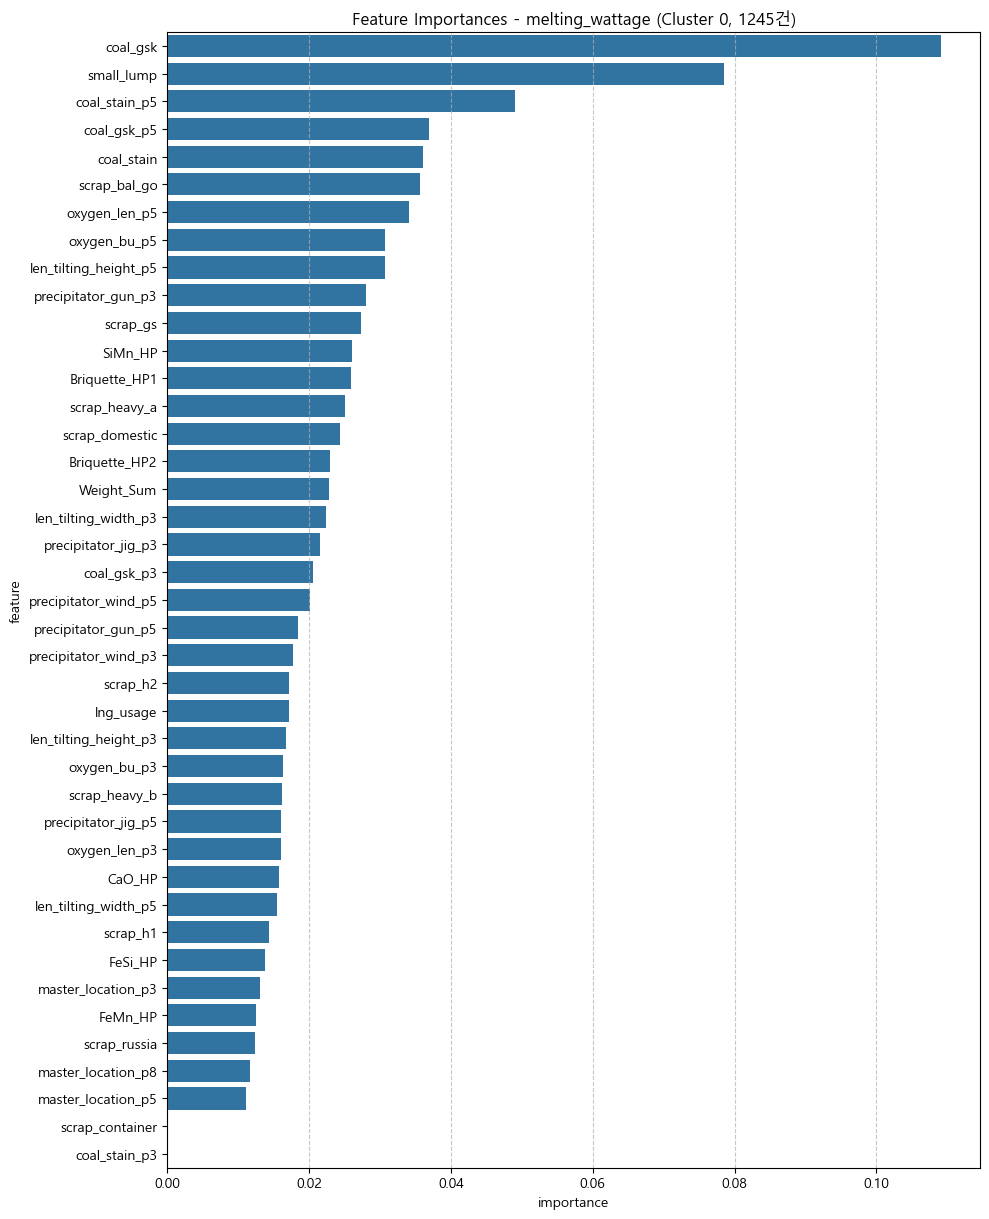


[Cluster 0 변수 중요도 순위]
                  feature  importance
34               coal_gsk    0.109159
36             small_lump    0.078480
40          coal_stain_p5    0.049058
38            coal_gsk_p5    0.036847
35             coal_stain    0.036046
24           scrap_bal_go    0.035639
16          oxygen_len_p5    0.034113
22           oxygen_bu_p5    0.030726
19  len_tilting_height_p5    0.030679
8     precipitator_gun_p3    0.028087
27               scrap_gs    0.027285
3                 SiMn_HP    0.026115
4           Briquette_HP1    0.025924
30          scrap_heavy_a    0.025017
26         scrap_domestic    0.024379
5           Briquette_HP2    0.022995
23             Weight_Sum    0.022760
18   len_tilting_width_p3    0.022421
6     precipitator_jig_p3    0.021588
37            coal_gsk_p3    0.020565
11   precipitator_wind_p5    0.020143
9     precipitator_gun_p5    0.018489
10   precipitator_wind_p3    0.017667
29               scrap_h2    0.017180
33              lng_usage  

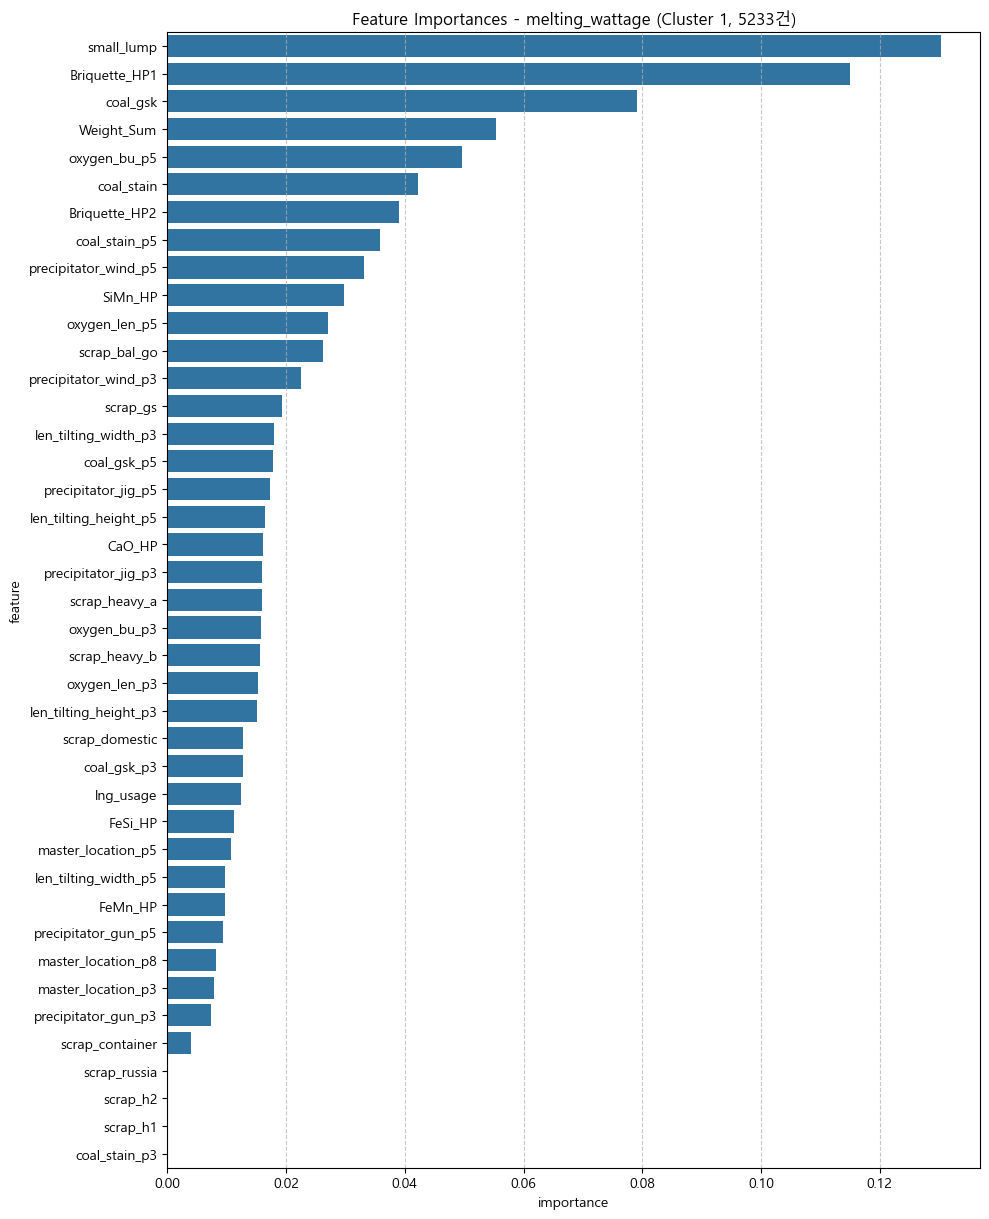


[Cluster 1 변수 중요도 순위]
                  feature  importance
36             small_lump    0.130357
4           Briquette_HP1    0.115003
34               coal_gsk    0.079134
23             Weight_Sum    0.055306
22           oxygen_bu_p5    0.049666
35             coal_stain    0.042212
5           Briquette_HP2    0.039092
40          coal_stain_p5    0.035878
11   precipitator_wind_p5    0.033166
3                 SiMn_HP    0.029754
16          oxygen_len_p5    0.027073
24           scrap_bal_go    0.026152
10   precipitator_wind_p3    0.022516
27               scrap_gs    0.019253
18   len_tilting_width_p3    0.017911
38            coal_gsk_p5    0.017786
7     precipitator_jig_p5    0.017266
19  len_tilting_height_p5    0.016461
0                  CaO_HP    0.016173
6     precipitator_jig_p3    0.016002
30          scrap_heavy_a    0.015913
21           oxygen_bu_p3    0.015808
31          scrap_heavy_b    0.015546
15          oxygen_len_p3    0.015261
17  len_tilting_height_p3  

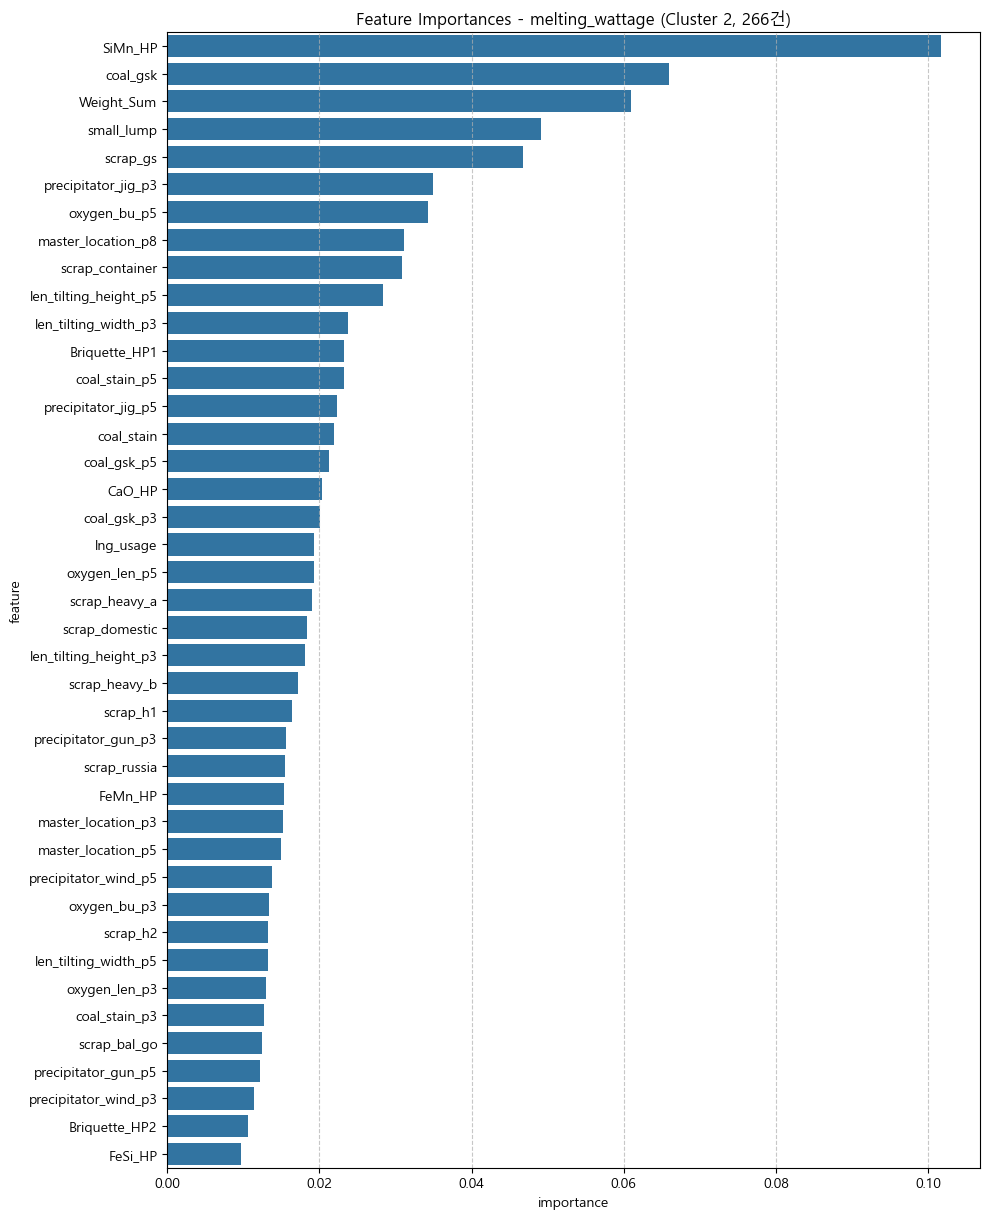


[Cluster 2 변수 중요도 순위]
                  feature  importance
3                 SiMn_HP    0.101751
34               coal_gsk    0.065943
23             Weight_Sum    0.060948
36             small_lump    0.049080
27               scrap_gs    0.046799
6     precipitator_jig_p3    0.034993
22           oxygen_bu_p5    0.034331
14     master_location_p8    0.031135
25        scrap_container    0.030908
19  len_tilting_height_p5    0.028322
18   len_tilting_width_p3    0.023769
4           Briquette_HP1    0.023269
40          coal_stain_p5    0.023240
7     precipitator_jig_p5    0.022286
35             coal_stain    0.021930
38            coal_gsk_p5    0.021199
0                  CaO_HP    0.020295
37            coal_gsk_p3    0.020027
33              lng_usage    0.019324
16          oxygen_len_p5    0.019305
30          scrap_heavy_a    0.019043
26         scrap_domestic    0.018364
17  len_tilting_height_p3    0.018158
31          scrap_heavy_b    0.017165
28               scrap_h1  

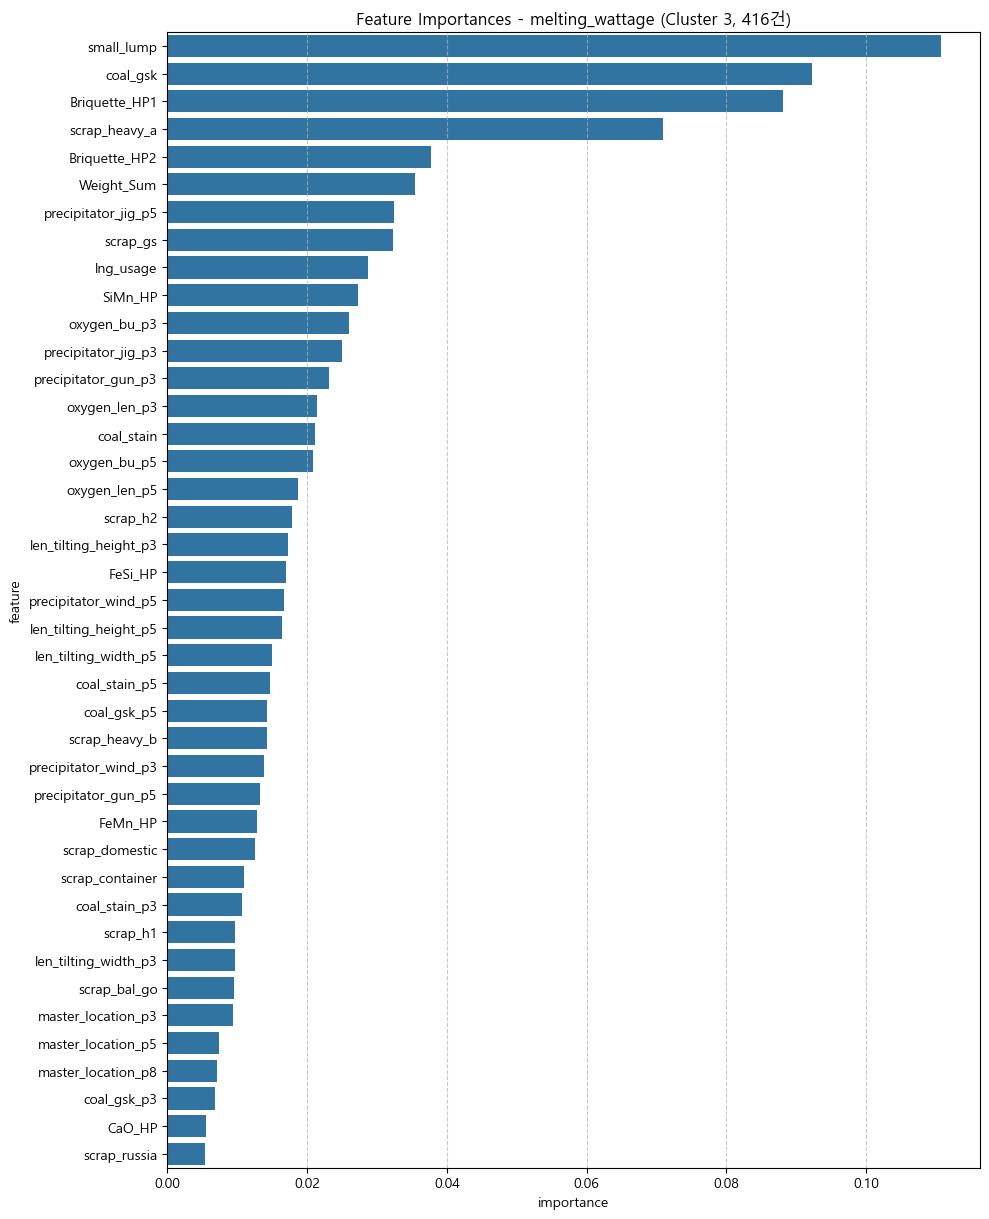


[Cluster 3 변수 중요도 순위]
                  feature  importance
36             small_lump    0.110749
34               coal_gsk    0.092190
4           Briquette_HP1    0.088040
30          scrap_heavy_a    0.070981
5           Briquette_HP2    0.037677
23             Weight_Sum    0.035392
7     precipitator_jig_p5    0.032469
27               scrap_gs    0.032297
33              lng_usage    0.028722
3                 SiMn_HP    0.027317
21           oxygen_bu_p3    0.026051
6     precipitator_jig_p3    0.024996
8     precipitator_gun_p3    0.023081
15          oxygen_len_p3    0.021370
35             coal_stain    0.021066
22           oxygen_bu_p5    0.020781
16          oxygen_len_p5    0.018633
29               scrap_h2    0.017911
17  len_tilting_height_p3    0.017208
2                 FeSi_HP    0.017057
11   precipitator_wind_p5    0.016671
19  len_tilting_height_p5    0.016344
20   len_tilting_width_p5    0.014925
40          coal_stain_p5    0.014737
38            coal_gsk_p5  

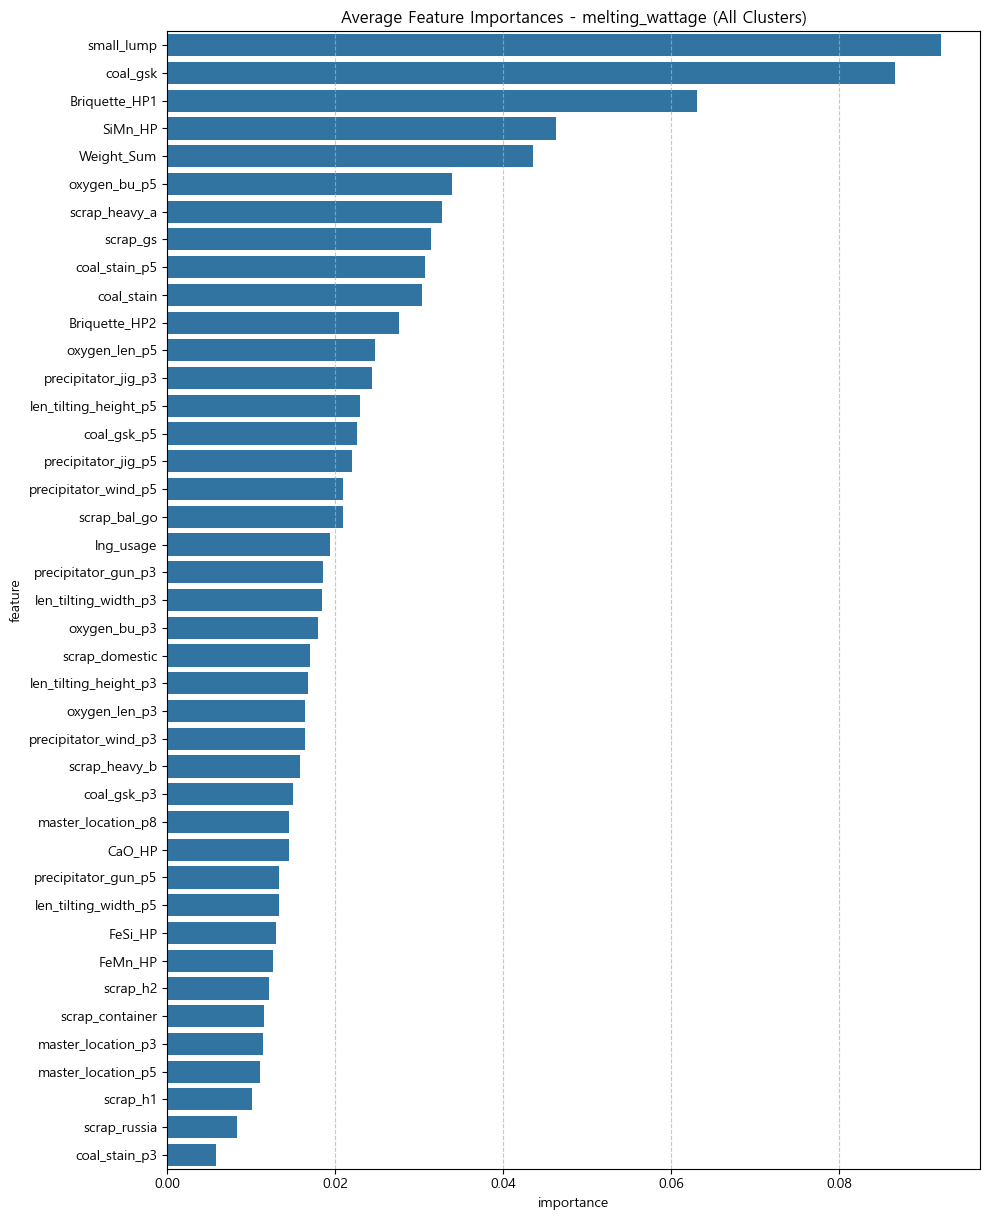


[전체 평균 변수 중요도 순위]
                  feature  importance
0              small_lump    0.092167
1                coal_gsk    0.086607
2           Briquette_HP1    0.063059
3                 SiMn_HP    0.046234
4              Weight_Sum    0.043601
5            oxygen_bu_p5    0.033876
6           scrap_heavy_a    0.032739
7                scrap_gs    0.031408
8           coal_stain_p5    0.030728
9              coal_stain    0.030314
10          Briquette_HP2    0.027587
11          oxygen_len_p5    0.024781
12    precipitator_jig_p3    0.024395
13  len_tilting_height_p5    0.022952
14            coal_gsk_p5    0.022536
15    precipitator_jig_p5    0.022024
16   precipitator_wind_p5    0.020949
17           scrap_bal_go    0.020943
18              lng_usage    0.019378
19    precipitator_gun_p3    0.018540
20   len_tilting_width_p3    0.018453
21           oxygen_bu_p3    0.017894
22         scrap_domestic    0.017003
23  len_tilting_height_p3    0.016805
24          oxygen_len_p3    0.

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 클러스터별 변수 중요도 추출 및 시각화
for c, model_c in models.items():
    importances = model_c.feature_importances_
    feature_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, len(X_train.columns) * 0.3))
    sns.barplot(x='importance', y='feature', data=feature_df)
    plt.title(f'Feature Importances - {TARGETS[0]} (Cluster {c}, {(train_clusters == c).sum()}건)')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(f"\n[Cluster {c} 변수 중요도 순위]")
    print(feature_df)
    print()

# 전체 평균 중요도
avg_importances = np.mean([m.feature_importances_ for m in models.values()], axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': avg_importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, len(X_train.columns) * 0.3))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title(f'Average Feature Importances - {TARGETS[0]} (All Clusters)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"\n[전체 평균 변수 중요도 순위]")
print(feature_importance_df)

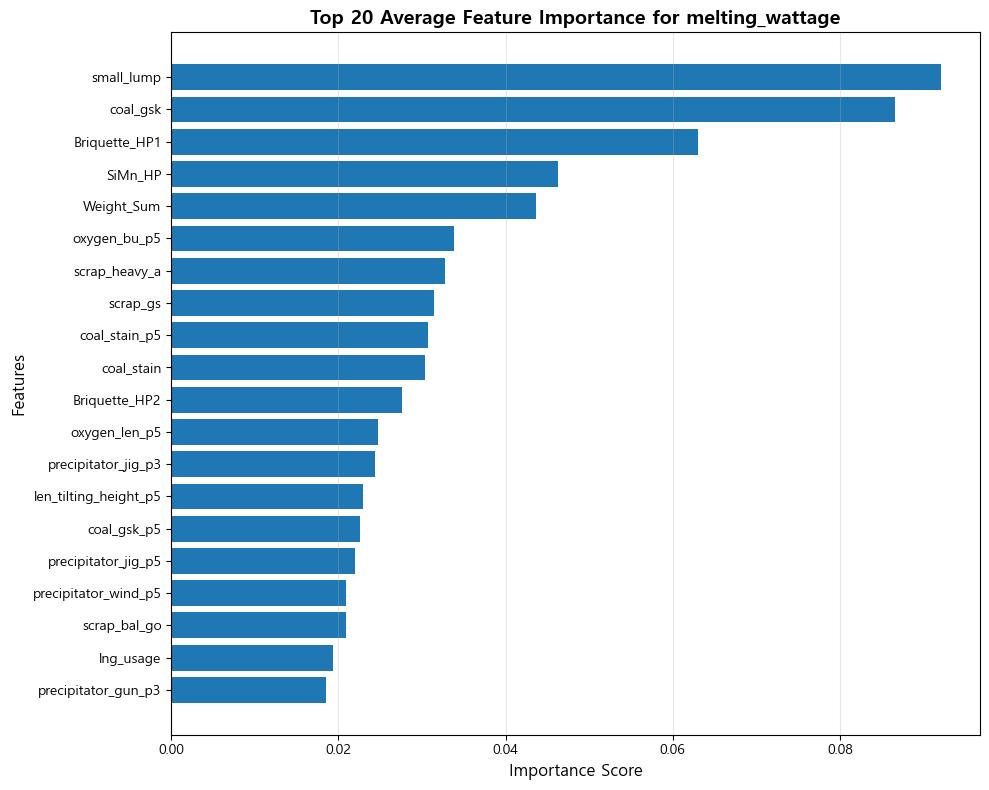

In [11]:
# Feature Importance Top 20 시각화 (평균 기준)
top_n = 20

plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Top {top_n} Average Feature Importance for {TARGETS[0]}', 
         fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

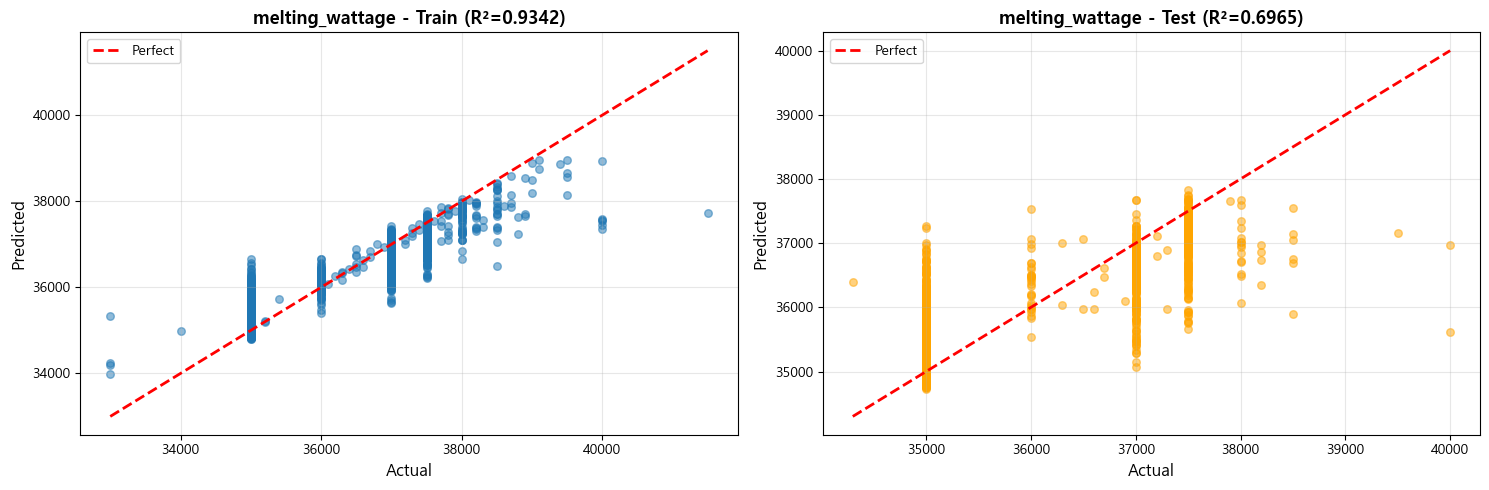

In [12]:
# 예측 vs 실제 시각화
n_targets = len(targets_to_evaluate)
fig, axes = plt.subplots(n_targets, 2, figsize=(15, 5*n_targets))

# 타겟이 1개일 때 axes 차원 조정
if n_targets == 1:
    axes = axes.reshape(1, -1)

for idx, (target_name, y_tr, y_te, y_pred_tr, y_pred_te) in enumerate(targets_to_evaluate):
    train_r2 = r2_score(y_tr, y_pred_tr)
    test_r2 = r2_score(y_te, y_pred_te)
    
    # Train set
    axes[idx, 0].scatter(y_tr, y_pred_tr, alpha=0.5, s=30)
    axes[idx, 0].plot([y_tr.min(), y_tr.max()],
                      [y_tr.min(), y_tr.max()], 'r--', lw=2, label='Perfect')
    axes[idx, 0].set_xlabel('Actual', fontsize=12)
    axes[idx, 0].set_ylabel('Predicted', fontsize=12)
    axes[idx, 0].set_title(f'{target_name} - Train (R²={train_r2:.4f})', 
                          fontsize=13, fontweight='bold')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Test set
    axes[idx, 1].scatter(y_te, y_pred_te, alpha=0.5, s=30, color='orange')
    axes[idx, 1].plot([y_te.min(), y_te.max()],
                      [y_te.min(), y_te.max()], 'r--', lw=2, label='Perfect')
    axes[idx, 1].set_xlabel('Actual', fontsize=12)
    axes[idx, 1].set_ylabel('Predicted', fontsize=12)
    axes[idx, 1].set_title(f'{target_name} - Test (R²={test_r2:.4f})', 
                          fontsize=13, fontweight='bold')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

targets_str = '_'.join(TARGETS)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import gc

print("교차 검증 수행 중 (GMM 분할 학습)...")

N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
cv_r2_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    X_cv_train, X_cv_val = X.iloc[train_idx], X.iloc[val_idx]
    y_cv_train = y.values.ravel()[train_idx]
    y_cv_val   = y.values.ravel()[val_idx]

    # (중요) fold 기준으로 스케일러 fit -> leakage 방지 + GMM 안정화
    sc = StandardScaler()
    X_tr_s = sc.fit_transform(X_cv_train.values)
    X_va_s = sc.transform(X_cv_val.values)

    # GMM은 스케일된 X로
    gmm_cv = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
    cv_train_clusters = gmm_cv.fit_predict(X_tr_s)
    cv_val_clusters   = gmm_cv.predict(X_va_s)

    # 1) global 모델(폴드 fallback)
    global_params = dict(params)
    global_params.update({"nthread": 4})  # 안정성
    global_model = xgb.XGBRegressor(**global_params)
    global_model.fit(X_cv_train, y_cv_train, verbose=False)

    y_cv_pred = global_model.predict(X_cv_val)  # 기본값을 global로 깔아둠

    # 2) 클러스터별로 있으면 덮어쓰기
    for c in range(best_n):
        tr_mask = (cv_train_clusters == c)
        va_mask = (cv_val_clusters == c)

        # 최소 샘플 조건(너무 작은 클러스터는 학습하지 않음)
        if tr_mask.sum() < 50 or va_mask.sum() == 0:
            continue

        m = xgb.XGBRegressor(**global_params)
        m.fit(X_cv_train.iloc[tr_mask], y_cv_train[tr_mask], verbose=False)
        y_cv_pred[va_mask] = m.predict(X_cv_val.iloc[va_mask])

        del m
        gc.collect()

    fold_r2 = r2_score(y_cv_val, y_cv_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
    cv_r2_scores.append(fold_r2)

    print(f"  Fold {fold}: R² = {fold_r2:.4f}, RMSE = {fold_rmse:.4f}")

    del global_model, gmm_cv
    gc.collect()

print("=" * 50)
print(f"{N_SPLITS}5-Fold CV 평균 R²: {np.mean(cv_r2_scores):.4f} (±{np.std(cv_r2_scores):.4f})")
print("=" * 50)


교차 검증 수행 중 (GMM 분할 학습)...
  Fold 1: R² = 0.6960, RMSE = 570.7194
  Fold 2: R² = 0.7159, RMSE = 539.4203
  Fold 3: R² = 0.6831, RMSE = 592.5699
  Fold 4: R² = 0.6804, RMSE = 593.0550
  Fold 5: R² = 0.6878, RMSE = 589.7536
55-Fold CV 평균 R²: 0.6927 (±0.0128)



【melting_wattage 잔차 통계】
  평균: -6.2263
  표준편차: 570.2563
  최대값: 4391.4531
  최소값: -2272.1914

💾 저장 완료: residuals_melting_wattage.png


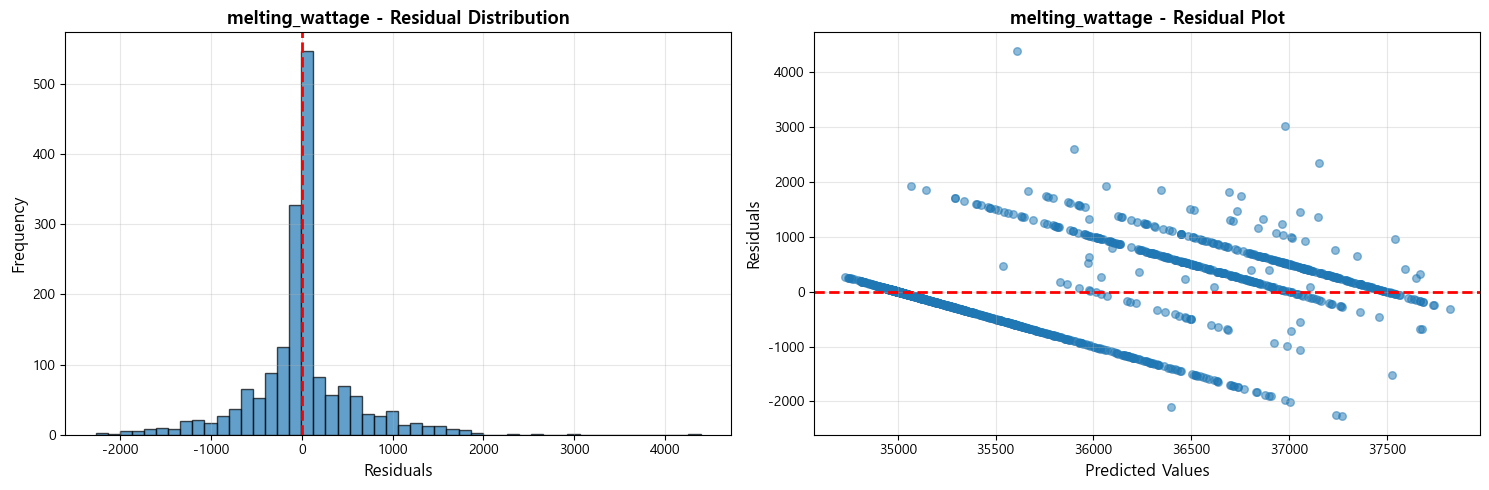

In [14]:
# 잔차 분석
n_targets = len(targets_to_evaluate)
fig, axes = plt.subplots(n_targets, 2, figsize=(15, 5*n_targets))
# 각 타겟별로 2개 그래프 (분포 히스토그램, 잔차 플롯)

if n_targets == 1:
    axes = axes.reshape(1, -1)

for idx, (target_name, y_tr, y_te, y_pred_tr, y_pred_te) in enumerate(targets_to_evaluate):
    residuals_test = y_te - y_pred_te  # 잔차 = 실제값 - 예측값
    # 양수: 과소예측 (실제가 더 큼)
    # 음수: 과대예측 (예측이 더 큼)
    
    # ===== 왼쪽: 잔차 분포 히스토그램 =====
    axes[idx, 0].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
    # hist: 히스토그램 (막대 그래프)
    #   - bins=50: 50개 구간으로 나눔
    #   - edgecolor='black': 막대 테두리 색
    #   - alpha=0.7: 투명도 70%
    
    axes[idx, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    # axvline: 수직선 그리기
    #   - x=0 위치에 빨간 점선
    #   - 이상적으로는 이 선을 중심으로 대칭이어야 함
    
    axes[idx, 0].set_xlabel('Residuals', fontsize=12)
    axes[idx, 0].set_ylabel('Frequency', fontsize=12)
    axes[idx, 0].set_title(f'{target_name} - Residual Distribution', 
                          fontsize=13, fontweight='bold')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # ===== 오른쪽: 잔차 vs 예측값 산점도 =====
    axes[idx, 1].scatter(y_pred_te, residuals_test, alpha=0.5, s=30)
    # x축: 예측값
    # y축: 잔차
    # 패턴 없이 무작위로 흩어져야 좋은 모델
    
    axes[idx, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    # axhline: 수평선 그리기
    #   - y=0 위치 (잔차 0)
    #   - 점들이 이 선 주위에 랜덤하게 분포해야 함
    
    axes[idx, 1].set_xlabel('Predicted Values', fontsize=12)
    axes[idx, 1].set_ylabel('Residuals', fontsize=12)
    axes[idx, 1].set_title(f'{target_name} - Residual Plot', 
                          fontsize=13, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)
    
    # 통계 정보 출력
    print(f"\n【{target_name} 잔차 통계】")
    print(f"  평균: {residuals_test.mean():.4f}")
    # 평균이 0에 가까워야 함 (편향 없음)
    
    print(f"  표준편차: {residuals_test.std():.4f}")
    # 오차의 퍼진 정도
    
    print(f"  최대값: {residuals_test.max():.4f}")
    # 가장 크게 과소예측한 경우
    
    print(f"  최소값: {residuals_test.min():.4f}")
    # 가장 크게 과대예측한 경우

targets_str = '_'.join(TARGETS)
plt.tight_layout()
plt.savefig(f'residuals_{targets_str}.png', dpi=300, bbox_inches='tight')
print(f"\n💾 저장 완료: residuals_{targets_str}.png")
plt.show()

In [15]:
from datetime import datetime

print("=" * 80)
print("XGBoost 모델 학습 결과 요약 (GMM 분할 학습)")
print("=" * 80)

print(f"\n【실험 정보】")
print(f"  실험 일시: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"  타겟 변수: {', '.join(TARGETS)}")
print(f"  GMM 클러스터 수: {best_n}")
print(f"  총 데이터 개수: {len(df_model)}")
print(f"  Train 데이터: {len(X_train)} ({len(X_train)/len(df_model)*100:.1f}%)")
print(f"  Test 데이터: {len(X_test)} ({len(X_test)/len(df_model)*100:.1f}%)")

print(f"\n【클러스터 분포】")
for c in range(best_n):
    print(f"  Cluster {c}: Train {(train_clusters == c).sum()}건, Test {(test_clusters == c).sum()}건")

print(f"\n【데이터 전처리】")
print(f"  결측치 → 0 (미투입 처리)")

print(f"\n【특성 정보】")
print(f"  총 특성 개수: {len(SELECTED_FEATURES)}")

print(f"\n【하이퍼파라미터】")
for key, value in params.items():
    print(f"  {key:25s}: {value}")

print(f"\n【모델 성능】")
for target_name, y_tr, y_te, y_pred_tr, y_pred_te in targets_to_evaluate:
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
    test_rmse = np.sqrt(mean_squared_error(y_te, y_pred_te))
    train_r2 = r2_score(y_tr, y_pred_tr)
    test_r2 = r2_score(y_te, y_pred_te)
    train_mae = mean_absolute_error(y_tr, y_pred_tr)
    test_mae = mean_absolute_error(y_te, y_pred_te)
    
    print(f"\n  ▶ {target_name}")
    print(f"    Train - RMSE: {train_rmse:>10.4f}  |  R²: {train_r2:>6.4f}  |  MAE: {train_mae:>10.4f}")
    print(f"    Test  - RMSE: {test_rmse:>10.4f}  |  R²: {test_r2:>6.4f}  |  MAE: {test_mae:>10.4f}")
    
    overfitting = train_r2 - test_r2
    if overfitting > 0.1:
        print(f"    ⚠️  과적합 감지 (R² 차이: {overfitting:.4f})")
    else:
        print(f"    ✅  과적합 없음 (R² 차이: {overfitting:.4f})")
    
    print(f"    타겟 범위: {y_te.min():.2f} ~ {y_te.max():.2f}")
    print(f"    타겟 평균: {y_te.mean():.2f} (표준편차: {y_te.std():.2f})")

print(f"\n【주요 특성 (Top 10, 평균 중요도)】")
for idx, row in feature_importance_df.head(10).iterrows():
    print(f"  {idx+1:2d}. {row['feature']:25s}  중요도: {row['importance']:.6f}")

print("\n" + "=" * 80)

XGBoost 모델 학습 결과 요약 (GMM 분할 학습)

【실험 정보】
  실험 일시: 2026-02-04 17:01:46
  타겟 변수: melting_wattage
  GMM 클러스터 수: 4
  총 데이터 개수: 8950
  Train 데이터: 7160 (80.0%)
  Test 데이터: 1790 (20.0%)

【클러스터 분포】
  Cluster 0: Train 1245건, Test 304건
  Cluster 1: Train 5233건, Test 1327건
  Cluster 2: Train 266건, Test 65건
  Cluster 3: Train 416건, Test 94건

【데이터 전처리】
  결측치 → 0 (미투입 처리)

【특성 정보】
  총 특성 개수: 41

【하이퍼파라미터】
  objective                : reg:squarederror
  random_state             : 42
  tree_method              : hist
  device                   : cuda
  sampling_method          : gradient_based
  max_bin                  : 256
  max_depth                : 6
  learning_rate            : 0.01223826357909319
  n_estimators             : 800
  subsample                : 0.7
  colsample_bytree         : 0.6
  min_child_weight         : 6
  gamma                    : 5.0
  reg_alpha                : 1.0
  reg_lambda               : 6.0
  eval_metric              : rmse

【모델 성능】

  ▶ melting_wattage
    Train

In [16]:
class ExperimentLogger:
    """실험 결과를 자동으로 기록하는 클래스"""
    
    def __init__(self, log_file='experiment_log_xgb.json'):
        self.log_file = log_file
        self.experiments = []
        self.load_existing_logs()
    
    def load_existing_logs(self):
        """기존 로그 불러오기"""
        try:
            with open(self.log_file, 'r', encoding='utf-8') as f:
                self.experiments = json.load(f)
            print(f"✅ 기존 로그 {len(self.experiments)}개 불러옴: {self.log_file}")
        except FileNotFoundError:
            print(f"📝 새로운 로그 파일 생성: {self.log_file}")
            self.experiments = []
    
    def log_experiment(self, target, features, params, results, feature_importance=None):
        """실험 결과 기록"""
        experiment = {
            'experiment_id': len(self.experiments) + 1,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'target': target,
            'n_features': len(features),
            'features': features,
            'params': params,
            'results': results,
            'feature_importance_top10': feature_importance
        }
        self.experiments.append(experiment)
        self.save()
        return experiment['experiment_id']
    
    def save(self):
        """로그 파일 저장"""
        with open(self.log_file, 'w', encoding='utf-8') as f:
            json.dump(self.experiments, f, ensure_ascii=False, indent=2)
    
    def get_best_experiment(self, target, metric='test_r2'):
        """특정 타겟의 최고 성능 실험 찾기"""
        target_exps = [e for e in self.experiments if e['target'] == target]
        if not target_exps:
            return None
        return max(target_exps, key=lambda x: x['results'][metric])
    
    def print_summary(self):
        """전체 실험 요약"""
        if len(self.experiments) == 0:
            print("아직 실험 기록이 없습니다.")
            return
        
        print(f"\n{'='*80}")
        print(f"📊 실험 기록 요약")
        print(f"{'='*80}")
        print(f"총 실험 횟수: {len(self.experiments)}")
        print(f"로그 파일: {self.log_file}")
        print(f"{'='*80}\n")
        
        # 타겟별 최고 성능
        targets = set(e['target'] for e in self.experiments)
        for target in sorted(targets):
            best = self.get_best_experiment(target)
            if best:
                print(f"[{target}] 최고 성능 (실험 #{best['experiment_id']})")
                print(f"  Test R²:    {best['results']['test_r2']:.4f}")
                print(f"  Test MAPE:  {best['results'].get('test_mape', 0):.2f}%")  # ✨ 추가
                print(f"  Test SMAPE: {best['results'].get('test_smape', 0):.2f}%") # ✨ 추가
                print(f"  Test RMSE:  {best['results']['test_rmse']:.4f}")
                print(f"  CV R²:      {best['results']['cv_r2']:.4f}")
                print(f"  실험 시각:  {best['timestamp']}")
                print(f"  특성 개수:  {best['n_features']}")
                print(f"  주요 파라미터:")
                print(f"    - max_depth: {best['params']['max_depth']}")
                print(f"    - learning_rate: {best['params']['learning_rate']:.4f}")
                print(f"    - n_estimators: {best['params']['n_estimators']}")
                print(f"  Top 5 특성: {', '.join(best['feature_importance_top10'][:5])}")
                print()
    
    def get_experiments_df(self):
        """실험 결과를 DataFrame으로 변환"""
        if len(self.experiments) == 0:
            return pd.DataFrame()
        
        records = []
        for exp in self.experiments:
            record = {
                'exp_id': exp['experiment_id'],
                'timestamp': exp['timestamp'],
                'target': exp['target'],
                'n_features': exp['n_features'],
                'test_r2': exp['results']['test_r2'],
                'test_mape': exp['results'].get('test_mape'),   # ✨ 추가
                'test_smape': exp['results'].get('test_smape'), # ✨ 추가
                'test_rmse': exp['results']['test_rmse'],
                'cv_r2': exp['results']['cv_r2'],
                'max_depth': exp['params']['max_depth'],
                'learning_rate': exp['params']['learning_rate'],
                'n_estimators': exp['params']['n_estimators'],
            }
            records.append(record)
        
        return pd.DataFrame(records)

# 로거 초기화
logger = ExperimentLogger('experiment_log_xgb.json')
logger.print_summary()

✅ 기존 로그 1개 불러옴: experiment_log_xgb.json

📊 실험 기록 요약
총 실험 횟수: 1
로그 파일: experiment_log_xgb.json

[tot_result1] 최고 성능 (실험 #1)
  Test R²:    0.1397
  Test MAPE:  2.05%
  Test SMAPE: 2.04%
  Test RMSE:  3.0110
  CV R²:      0.1449
  실험 시각:  2026-02-04 16:36:27
  특성 개수:  53
  주요 파라미터:
    - max_depth: 4
    - learning_rate: 0.0112
    - n_estimators: 200
  Top 5 특성: scrap_gs, SiMn_HP, scrap_domestic, Weight_Sum, scrap_heavy_b



In [17]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import gc

def objective(trial, target_name, X_data, y_data):
    params = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 900, step=50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'tree_method': 'hist',
        'device': 'cpu',   # 안정화 후 cuda로 바꾸고 싶으면 여기만 변경
        'nthread': 4
    }

    N_SPLITS = 5  # 속도 개선(원하면 10으로)
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    fold_r2s = []

    X_df = X_data
    y_arr = y_data.values.ravel()

    for train_idx, val_idx in kf.split(X_df):
        X_tr = X_df.iloc[train_idx]
        X_val = X_df.iloc[val_idx]
        y_tr = y_arr[train_idx]
        y_val = y_arr[val_idx]

        # fold별 스케일링 -> GMM 안정화/일관성
        sc = StandardScaler()
        X_tr_s = sc.fit_transform(X_tr.values)
        X_val_s = sc.transform(X_val.values)

        # GMM은 스케일된 X로
        gmm_cv = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
        tr_clusters = gmm_cv.fit_predict(X_tr_s)
        val_clusters = gmm_cv.predict(X_val_s)

        # (핵심) global fallback으로 예측값을 먼저 채움
        global_model = xgb.XGBRegressor(**params)
        global_model.fit(X_tr, y_tr, verbose=False)
        y_pred = global_model.predict(X_val)

        # 클러스터별 덮어쓰기(조건 만족 시에만)
        MIN_CLUSTER = 100
        for c in range(best_n):
            tr_mask = (tr_clusters == c)
            val_mask = (val_clusters == c)

            if tr_mask.sum() < MIN_CLUSTER or val_mask.sum() == 0:
                continue

            m = xgb.XGBRegressor(**params)
            m.fit(X_tr.iloc[tr_mask], y_tr[tr_mask], verbose=False)
            y_pred[val_mask] = m.predict(X_val.iloc[val_mask])

            del m
            gc.collect()

        fold_r2s.append(r2_score(y_val, y_pred))

        del global_model, gmm_cv, sc
        gc.collect()

    return float(np.mean(fold_r2s))


In [18]:
# 필요한 import (없으면 추가)
import numpy as np
import pandas as pd
import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def run_optimization(target_name, n_trials=100, timeout=None):
    """GMM 분할 학습 기반 하이퍼파라미터 자동 최적화"""

    print(f"\n{'='*80}")
    print(f"[{target_name}] 하이퍼파라미터 최적화 시작 (GMM {best_n}그룹)")
    print(f"{'='*80}")
    print(f"시도 횟수: {n_trials}")
    if timeout:
        print(f"최대 시간: {timeout}초")
    print(f"{'='*80}\n")

    TARGETS_OPTUNA = [target_name]
    df_model_optuna = df_processed.dropna(subset=TARGETS_OPTUNA)

    X_data = df_model_optuna[SELECTED_FEATURES]
    y_data = df_model_optuna[target_name]

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42
    )

    print(f"전체 데이터: {len(X_data)}")
    print(f"학습용: {len(X_tr)} | 테스트용: {len(X_te)}")
    print(f"특성 개수: {len(SELECTED_FEATURES)}\n")

    study = optuna.create_study(
        direction='maximize',
        study_name=f'{target_name}_gmm_opt_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    )

    study.optimize(
        lambda trial: objective(trial, target_name, X_tr, y_tr),
        n_trials=n_trials,
        timeout=timeout,
        n_jobs=1,
        show_progress_bar=True
    )

    print(f"\n{'='*80}")
    print(f"최적화 완료! 최고 CV R²: {study.best_value:.4f}")
    print(f"{'='*80}")
    print(f"\n최적 하이퍼파라미터:")
    for key, value in study.best_params.items():
        if isinstance(value, float):
            print(f"  {key:25s}: {value:.6f}")
        else:
            print(f"  {key:25s}: {value}")

    # 최적 파라미터로 GMM 분할 학습
    print(f"\n{'='*80}")
    print(f"최적 파라미터로 최종 모델 학습 중 (GMM {best_n}그룹)...")
    print(f"{'='*80}\n")

    opt_params = {
        'objective': 'reg:squarederror',
        'random_state': 42,
        'tree_method': 'hist',
        'device': 'cpu',   # 완주 확인 후 cuda로 바꾸고 싶으면 여기만 변경
        'nthread': 4,
        **study.best_params
    }

    # GMM 분할 (스케일링 일관화)
    sc = StandardScaler()
    X_tr_s = sc.fit_transform(X_tr.values)
    X_te_s = sc.transform(X_te.values)

    gmm_opt = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
    tr_clusters = gmm_opt.fit_predict(X_tr_s)
    te_clusters = gmm_opt.predict(X_te_s)

    # (1) 전역 모델로 기본 예측값 채우기 (미할당 방지)
    global_model = xgb.XGBRegressor(**opt_params)
    global_model.fit(X_tr, y_tr.values, verbose=False)

    y_pred_tr = global_model.predict(X_tr)
    y_pred_te = global_model.predict(X_te)

    # (2) 클러스터별 모델이 있으면 덮어쓰기
    opt_models = {'global': global_model}
    MIN_CLUSTER = 100  # objective와 맞추는 걸 권장

    for c in range(best_n):
        tr_mask = (tr_clusters == c)
        te_mask = (te_clusters == c)

        if tr_mask.sum() < MIN_CLUSTER:
            continue  # 너무 작은 클러스터는 건너뛰고 global 유지

        m = xgb.XGBRegressor(**opt_params)
        m.fit(X_tr.loc[tr_mask], y_tr.values[tr_mask], verbose=False)
        opt_models[c] = m

        # train 덮어쓰기
        y_pred_tr[tr_mask] = m.predict(X_tr.loc[tr_mask])
        # test 덮어쓰기 (있을 때만)
        if te_mask.sum() > 0:
            y_pred_te[te_mask] = m.predict(X_te.loc[te_mask])

        del m
        gc.collect()

    def get_mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

    def get_smape(y_true, y_pred):
        return 100 / len(y_true) * np.sum(
            2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-9)
        )

    results = {
        'train_rmse': float(np.sqrt(mean_squared_error(y_tr, y_pred_tr))),
        'test_rmse': float(np.sqrt(mean_squared_error(y_te, y_pred_te))),
        'train_r2': float(r2_score(y_tr, y_pred_tr)),
        'test_r2': float(r2_score(y_te, y_pred_te)),
        'test_mae': float(mean_absolute_error(y_te, y_pred_te)),
        'test_mape': float(get_mape(y_te.values, y_pred_te)),
        'test_smape': float(get_smape(y_te.values, y_pred_te)),
        'cv_r2': float(study.best_value),
        'n_trials': len(study.trials),
        'gmm_n_components': best_n,
    }

    print("최종 모델 성능:")
    print(f"  Train R²:   {results['train_r2']:.4f}  |  RMSE: {results['train_rmse']:.4f}")
    print(f"  Test R²:    {results['test_r2']:.4f}  |  RMSE: {results['test_rmse']:.4f}")
    print(f"  Test MAE:   {results['test_mae']:.4f}")
    print(f"  Test MAPE:  {results['test_mape']:.2f}%")
    print(f"  Test SMAPE: {results['test_smape']:.2f}%")
    print(f"  CV R²:      {results['cv_r2']:.4f}")

    overfitting = results['train_r2'] - results['test_r2']
    if overfitting > 0.1:
        print(f"  ⚠️  과적합 감지 (R² 차이: {overfitting:.4f})")
    else:
        print(f"  ✅  과적합 없음 (R² 차이: {overfitting:.4f})")

    # Feature Importance (평균) - 클러스터 모델 없으면 global 사용
    cluster_models = [m for k, m in opt_models.items() if k != 'global']
    if len(cluster_models) > 0:
        avg_imp = np.mean([m.feature_importances_ for m in cluster_models], axis=0)
    else:
        avg_imp = opt_models['global'].feature_importances_

    feature_importance = pd.DataFrame({
        'feature': SELECTED_FEATURES,
        'importance': avg_imp
    }).sort_values('importance', ascending=False)

    print(f"\n주요 특성 Top 10:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"  {idx+1:2d}. {row['feature']:25s}  {row['importance']:.6f}")

    top10_features = feature_importance.head(10)['feature'].tolist()

    exp_id = logger.log_experiment(
        target=target_name,
        features=SELECTED_FEATURES,
        params=opt_params,
        results=results,
        feature_importance=top10_features
    )

    print(f"\n실험 결과 저장 완료 (실험 번호: #{exp_id})")

    return study, opt_models, results

print("최적화 함수 정의 완료 (GMM 분할 학습)")


최적화 함수 정의 완료 (GMM 분할 학습)


In [ ]:
# ===== 여기를 수정해서 실험 =====
TARGET_OPTUNA = 'melting_wattage'  # 예측할 타겟
N_TRIALS = 200                  # 시도 횟수 (많을수록 정확하지만 느림)
TIMEOUT = None                  # 최대 시간(초) - None이면 무제한
# ===================================

study, model_optuna, results_optuna = run_optimization(
    TARGET_OPTUNA, 
    n_trials=N_TRIALS, 
    timeout=TIMEOUT
)

[I 2026-02-04 17:01:46,072] A new study created in memory with name: melting_wattage_gmm_opt_20260204_170146



[melting_wattage] 하이퍼파라미터 최적화 시작 (GMM 4그룹)
시도 횟수: 200

전체 데이터: 8950
학습용: 7160 | 테스트용: 1790
특성 개수: 41



Best trial: 0. Best value: 0.66606:   0%|          | 1/200 [00:08<26:33,  8.01s/it]

[I 2026-02-04 17:01:54,079] Trial 0 finished with value: 0.6660603447133533 and parameters: {'max_depth': 4, 'learning_rate': 0.057529197646334525, 'n_estimators': 450, 'subsample': 0.778655310076446, 'colsample_bytree': 0.9512973765649897, 'min_child_weight': 8, 'gamma': 0.08466999023151234, 'reg_alpha': 0.9898485500749677, 'reg_lambda': 4.337229957673511}. Best is trial 0 with value: 0.6660603447133533.


Best trial: 1. Best value: 0.677857:   1%|          | 2/200 [00:18<31:01,  9.40s/it]

[I 2026-02-04 17:02:04,458] Trial 1 finished with value: 0.6778572990528016 and parameters: {'max_depth': 5, 'learning_rate': 0.04980146250530243, 'n_estimators': 550, 'subsample': 0.5431766723435156, 'colsample_bytree': 0.8491853501299298, 'min_child_weight': 6, 'gamma': 1.0419569505077686, 'reg_alpha': 0.8024967031354019, 'reg_lambda': 7.32582003163618}. Best is trial 1 with value: 0.6778572990528016.


Best trial: 2. Best value: 0.687078:   2%|▏         | 3/200 [00:34<40:28, 12.33s/it]

[I 2026-02-04 17:02:20,261] Trial 2 finished with value: 0.6870783496003255 and parameters: {'max_depth': 6, 'learning_rate': 0.026145842439637374, 'n_estimators': 850, 'subsample': 0.8276705557211395, 'colsample_bytree': 0.5542037250456461, 'min_child_weight': 5, 'gamma': 2.589984340516752, 'reg_alpha': 0.0012919583217448904, 'reg_lambda': 4.4866314891451164}. Best is trial 2 with value: 0.6870783496003255.


Best trial: 2. Best value: 0.687078:   2%|▏         | 4/200 [00:44<37:52, 11.59s/it]

[I 2026-02-04 17:02:30,730] Trial 3 finished with value: 0.6751630490433589 and parameters: {'max_depth': 5, 'learning_rate': 0.0286813099921431, 'n_estimators': 600, 'subsample': 0.9423517571129477, 'colsample_bytree': 0.5594942089157023, 'min_child_weight': 3, 'gamma': 2.8925294386458766, 'reg_alpha': 0.8138362078731733, 'reg_lambda': 9.085802882106421}. Best is trial 2 with value: 0.6870783496003255.


Best trial: 2. Best value: 0.687078:   2%|▎         | 5/200 [01:03<46:35, 14.34s/it]

[I 2026-02-04 17:02:49,934] Trial 4 finished with value: 0.6768303813991553 and parameters: {'max_depth': 6, 'learning_rate': 0.012348881511854449, 'n_estimators': 900, 'subsample': 0.9797644876659808, 'colsample_bytree': 0.7824233050527205, 'min_child_weight': 5, 'gamma': 3.232099887751445, 'reg_alpha': 0.02657570184468372, 'reg_lambda': 6.1652066860116514}. Best is trial 2 with value: 0.6870783496003255.


Best trial: 2. Best value: 0.687078:   3%|▎         | 6/200 [01:12<40:22, 12.48s/it]

[I 2026-02-04 17:02:58,823] Trial 5 finished with value: 0.679311608543333 and parameters: {'max_depth': 6, 'learning_rate': 0.04444630249177365, 'n_estimators': 400, 'subsample': 0.975749943294351, 'colsample_bytree': 0.6059617019411019, 'min_child_weight': 10, 'gamma': 4.225523866854691, 'reg_alpha': 0.7319488188279718, 'reg_lambda': 2.604625094144013}. Best is trial 2 with value: 0.6870783496003255.


Best trial: 2. Best value: 0.687078:   4%|▎         | 7/200 [01:19<33:44, 10.49s/it]

[I 2026-02-04 17:03:05,199] Trial 6 finished with value: 0.618801294441719 and parameters: {'max_depth': 4, 'learning_rate': 0.014048989863772607, 'n_estimators': 300, 'subsample': 0.9101402525551967, 'colsample_bytree': 0.7991609998120369, 'min_child_weight': 7, 'gamma': 3.4118031973583323, 'reg_alpha': 0.9908505988621679, 'reg_lambda': 7.843646660294366}. Best is trial 2 with value: 0.6870783496003255.


Best trial: 2. Best value: 0.687078:   4%|▍         | 8/200 [01:27<31:15,  9.77s/it]

[I 2026-02-04 17:03:13,428] Trial 7 finished with value: 0.6800578211953716 and parameters: {'max_depth': 5, 'learning_rate': 0.0489087266735392, 'n_estimators': 450, 'subsample': 0.8300882290432009, 'colsample_bytree': 0.5985167875701518, 'min_child_weight': 8, 'gamma': 0.077090440549481, 'reg_alpha': 0.3948545791470661, 'reg_lambda': 9.564766425244697}. Best is trial 2 with value: 0.6870783496003255.


Best trial: 2. Best value: 0.687078:   4%|▍         | 9/200 [01:36<30:46,  9.67s/it]

[I 2026-02-04 17:03:22,875] Trial 8 finished with value: 0.6660335517203293 and parameters: {'max_depth': 4, 'learning_rate': 0.024812983448398482, 'n_estimators': 750, 'subsample': 0.8230768834152786, 'colsample_bytree': 0.6011648081758063, 'min_child_weight': 2, 'gamma': 1.6920063307646789, 'reg_alpha': 0.6538601145459151, 'reg_lambda': 0.41978622870388005}. Best is trial 2 with value: 0.6870783496003255.


Best trial: 2. Best value: 0.687078:   5%|▌         | 10/200 [01:51<36:00, 11.37s/it]

[I 2026-02-04 17:03:38,064] Trial 9 finished with value: 0.685289874498686 and parameters: {'max_depth': 6, 'learning_rate': 0.03924274285526464, 'n_estimators': 650, 'subsample': 0.8775406898042084, 'colsample_bytree': 0.8798528805236611, 'min_child_weight': 5, 'gamma': 1.12929053126197, 'reg_alpha': 0.167018273042282, 'reg_lambda': 2.634235289713136}. Best is trial 2 with value: 0.6870783496003255.


Best trial: 2. Best value: 0.687078:   6%|▌         | 11/200 [02:00<33:09, 10.53s/it]

[I 2026-02-04 17:03:46,676] Trial 10 finished with value: 0.6599908741567294 and parameters: {'max_depth': 3, 'learning_rate': 0.08456818118471172, 'n_estimators': 900, 'subsample': 0.6713266813884009, 'colsample_bytree': 0.6908045953159632, 'min_child_weight': 1, 'gamma': 4.964947653087544, 'reg_alpha': 0.3527156992145633, 'reg_lambda': 4.50926508219164}. Best is trial 2 with value: 0.6870783496003255.


Best trial: 2. Best value: 0.687078:   6%|▌         | 12/200 [02:18<40:04, 12.79s/it]

[I 2026-02-04 17:04:04,648] Trial 11 finished with value: 0.683837620398202 and parameters: {'max_depth': 6, 'learning_rate': 0.018559462326165132, 'n_estimators': 750, 'subsample': 0.7007226695970084, 'colsample_bytree': 0.9427373312048153, 'min_child_weight': 4, 'gamma': 1.9732801669842752, 'reg_alpha': 0.004608374999101356, 'reg_lambda': 2.5847562352221605}. Best is trial 2 with value: 0.6870783496003255.


Best trial: 2. Best value: 0.687078:   6%|▋         | 13/200 [02:33<42:18, 13.58s/it]

[I 2026-02-04 17:04:20,023] Trial 12 finished with value: 0.6862120241213511 and parameters: {'max_depth': 6, 'learning_rate': 0.032644699957241737, 'n_estimators': 750, 'subsample': 0.8785475604541746, 'colsample_bytree': 0.6892285718158441, 'min_child_weight': 5, 'gamma': 1.3376122851309322, 'reg_alpha': 0.19536593649874878, 'reg_lambda': 2.5509487279771323}. Best is trial 2 with value: 0.6870783496003255.


Best trial: 13. Best value: 0.687187:   7%|▋         | 14/200 [02:49<43:55, 14.17s/it]

[I 2026-02-04 17:04:35,558] Trial 13 finished with value: 0.6871869104239963 and parameters: {'max_depth': 6, 'learning_rate': 0.021202062946197135, 'n_estimators': 800, 'subsample': 0.7567116777971011, 'colsample_bytree': 0.6806330417951857, 'min_child_weight': 4, 'gamma': 2.2674610139251814, 'reg_alpha': 0.20003588071218348, 'reg_lambda': 0.39825327788662257}. Best is trial 13 with value: 0.6871869104239963.


Best trial: 13. Best value: 0.687187:   8%|▊         | 15/200 [03:07<47:34, 15.43s/it]

[I 2026-02-04 17:04:53,907] Trial 14 finished with value: 0.676327044464771 and parameters: {'max_depth': 5, 'learning_rate': 0.019480417847241572, 'n_estimators': 850, 'subsample': 0.623290002838665, 'colsample_bytree': 0.5032433778999642, 'min_child_weight': 3, 'gamma': 2.1747154723831272, 'reg_alpha': 0.18930317944922334, 'reg_lambda': 0.30745641364743737}. Best is trial 13 with value: 0.6871869104239963.


Best trial: 13. Best value: 0.687187:   8%|▊         | 16/200 [03:20<44:37, 14.55s/it]

[I 2026-02-04 17:05:06,423] Trial 15 finished with value: 0.6425790075837092 and parameters: {'max_depth': 3, 'learning_rate': 0.019968533790990846, 'n_estimators': 800, 'subsample': 0.7367674563842342, 'colsample_bytree': 0.6931221891821663, 'min_child_weight': 3, 'gamma': 2.599859617443814, 'reg_alpha': 0.3847521010512588, 'reg_lambda': 1.291462921022129}. Best is trial 13 with value: 0.6871869104239963.


Best trial: 13. Best value: 0.687187:   8%|▊         | 17/200 [03:40<49:27, 16.21s/it]

[I 2026-02-04 17:05:26,505] Trial 16 finished with value: 0.6701409095348684 and parameters: {'max_depth': 6, 'learning_rate': 0.010553460309399734, 'n_estimators': 650, 'subsample': 0.7823521362241681, 'colsample_bytree': 0.5240534065401898, 'min_child_weight': 6, 'gamma': 3.9217844112316502, 'reg_alpha': 0.11643970324476038, 'reg_lambda': 5.620165241236841}. Best is trial 13 with value: 0.6871869104239963.


Best trial: 13. Best value: 0.687187:   9%|▉         | 18/200 [04:00<52:31, 17.32s/it]

[I 2026-02-04 17:05:46,392] Trial 17 finished with value: 0.6757362703864802 and parameters: {'max_depth': 5, 'learning_rate': 0.015433939033475914, 'n_estimators': 800, 'subsample': 0.616621286559961, 'colsample_bytree': 0.656826517512054, 'min_child_weight': 4, 'gamma': 2.434890639482873, 'reg_alpha': 0.29635049703951416, 'reg_lambda': 3.8474095757804734}. Best is trial 13 with value: 0.6871869104239963.


Best trial: 13. Best value: 0.687187:  10%|▉         | 19/200 [04:26<1:00:20, 20.00s/it]

[I 2026-02-04 17:06:12,644] Trial 18 finished with value: 0.6820798327856591 and parameters: {'max_depth': 6, 'learning_rate': 0.025527656811919538, 'n_estimators': 700, 'subsample': 0.5078463755596464, 'colsample_bytree': 0.7529300378481768, 'min_child_weight': 1, 'gamma': 0.7227405466401955, 'reg_alpha': 0.5431974411649315, 'reg_lambda': 1.339086425998478}. Best is trial 13 with value: 0.6871869104239963.


Best trial: 13. Best value: 0.687187:  10%|█         | 20/200 [04:46<59:49, 19.94s/it]  

[I 2026-02-04 17:06:32,449] Trial 19 finished with value: 0.6854511145402438 and parameters: {'max_depth': 5, 'learning_rate': 0.03406273682799867, 'n_estimators': 850, 'subsample': 0.725359752423922, 'colsample_bytree': 0.6366796223446753, 'min_child_weight': 10, 'gamma': 3.501133774611307, 'reg_alpha': 0.499421443903602, 'reg_lambda': 6.845497452534459}. Best is trial 13 with value: 0.6871869104239963.


Best trial: 13. Best value: 0.687187:  10%|█         | 21/200 [05:11<1:03:55, 21.43s/it]

[I 2026-02-04 17:06:57,338] Trial 20 finished with value: 0.680964962898585 and parameters: {'max_depth': 6, 'learning_rate': 0.06639511294811966, 'n_estimators': 900, 'subsample': 0.8370707354843536, 'colsample_bytree': 0.5533859155500276, 'min_child_weight': 7, 'gamma': 1.829314736074068, 'reg_alpha': 0.10674297360373594, 'reg_lambda': 3.3808902395569653}. Best is trial 13 with value: 0.6871869104239963.


Best trial: 13. Best value: 0.687187:  11%|█         | 22/200 [05:36<1:06:43, 22.49s/it]

[I 2026-02-04 17:07:22,306] Trial 21 finished with value: 0.6860379087316961 and parameters: {'max_depth': 6, 'learning_rate': 0.03355930869958509, 'n_estimators': 750, 'subsample': 0.8801832050202025, 'colsample_bytree': 0.7083916095911509, 'min_child_weight': 4, 'gamma': 1.2718573762231662, 'reg_alpha': 0.2470986696529331, 'reg_lambda': 1.6770100560957606}. Best is trial 13 with value: 0.6871869104239963.


Best trial: 22. Best value: 0.68916:  12%|█▏        | 23/200 [06:02<1:09:47, 23.66s/it] 

[I 2026-02-04 17:07:48,698] Trial 22 finished with value: 0.6891600777045943 and parameters: {'max_depth': 6, 'learning_rate': 0.024619757629043598, 'n_estimators': 800, 'subsample': 0.7839372584690965, 'colsample_bytree': 0.7379608946629815, 'min_child_weight': 5, 'gamma': 1.541920151100928, 'reg_alpha': 0.0745353041938256, 'reg_lambda': 5.15769455986417}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  12%|█▏        | 24/200 [06:29<1:12:24, 24.68s/it]

[I 2026-02-04 17:08:15,771] Trial 23 finished with value: 0.6863307901108847 and parameters: {'max_depth': 6, 'learning_rate': 0.02279111984760521, 'n_estimators': 850, 'subsample': 0.794180102106036, 'colsample_bytree': 0.7354690489304874, 'min_child_weight': 6, 'gamma': 2.8208133406881903, 'reg_alpha': 0.08751583276902578, 'reg_lambda': 5.821582090281828}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  12%|█▎        | 25/200 [06:49<1:07:46, 23.24s/it]

[I 2026-02-04 17:08:35,629] Trial 24 finished with value: 0.6773002227635601 and parameters: {'max_depth': 5, 'learning_rate': 0.015740014100178196, 'n_estimators': 800, 'subsample': 0.6825144109241887, 'colsample_bytree': 0.6433893350241408, 'min_child_weight': 4, 'gamma': 2.279466415654403, 'reg_alpha': 0.014091991243257052, 'reg_lambda': 5.155732200433333}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  13%|█▎        | 26/200 [07:09<1:04:28, 22.23s/it]

[I 2026-02-04 17:08:55,516] Trial 25 finished with value: 0.6869880552164502 and parameters: {'max_depth': 6, 'learning_rate': 0.028045836051918193, 'n_estimators': 700, 'subsample': 0.7643663486305057, 'colsample_bytree': 0.8037617230644062, 'min_child_weight': 7, 'gamma': 0.7189300551689115, 'reg_alpha': 0.27047170687000066, 'reg_lambda': 3.4820154022718297}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  14%|█▎        | 27/200 [07:20<54:02, 18.75s/it]  

[I 2026-02-04 17:09:06,129] Trial 26 finished with value: 0.6759163429336817 and parameters: {'max_depth': 5, 'learning_rate': 0.021182275497942906, 'n_estimators': 550, 'subsample': 0.6384811249976206, 'colsample_bytree': 0.8509751752909331, 'min_child_weight': 2, 'gamma': 1.7688856179651569, 'reg_alpha': 0.08655443038693567, 'reg_lambda': 7.949482954371886}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  14%|█▍        | 28/200 [07:37<52:52, 18.45s/it]

[I 2026-02-04 17:09:23,879] Trial 27 finished with value: 0.6868396417680731 and parameters: {'max_depth': 6, 'learning_rate': 0.017088973599387283, 'n_estimators': 850, 'subsample': 0.7388423485541671, 'colsample_bytree': 0.752889565593959, 'min_child_weight': 5, 'gamma': 3.007084690951239, 'reg_alpha': 0.47244175175082903, 'reg_lambda': 4.997049991962397}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  14%|█▍        | 29/200 [07:49<46:58, 16.48s/it]

[I 2026-02-04 17:09:35,785] Trial 28 finished with value: 0.6694053632286725 and parameters: {'max_depth': 4, 'learning_rate': 0.03831147547565558, 'n_estimators': 700, 'subsample': 0.813656021299592, 'colsample_bytree': 0.9897824504730067, 'min_child_weight': 3, 'gamma': 1.5661986541717983, 'reg_alpha': 0.1528192354312939, 'reg_lambda': 8.907740076722655}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  15%|█▌        | 30/200 [08:04<45:12, 15.96s/it]

[I 2026-02-04 17:09:50,507] Trial 29 finished with value: 0.6880363034667696 and parameters: {'max_depth': 6, 'learning_rate': 0.024088486225960812, 'n_estimators': 800, 'subsample': 0.8563584407108421, 'colsample_bytree': 0.5626408062891213, 'min_child_weight': 8, 'gamma': 0.6907363117874019, 'reg_alpha': 0.2343521959917953, 'reg_lambda': 6.577381460357522}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  16%|█▌        | 31/200 [08:19<44:00, 15.62s/it]

[I 2026-02-04 17:10:05,348] Trial 30 finished with value: 0.6630013450628145 and parameters: {'max_depth': 5, 'learning_rate': 0.012473071059791507, 'n_estimators': 650, 'subsample': 0.913589258959821, 'colsample_bytree': 0.6541133681661249, 'min_child_weight': 8, 'gamma': 0.5340388248982098, 'reg_alpha': 0.32728967254187186, 'reg_lambda': 6.554541282976752}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  16%|█▌        | 32/200 [08:42<50:14, 17.94s/it]

[I 2026-02-04 17:10:28,712] Trial 31 finished with value: 0.6867729437575246 and parameters: {'max_depth': 6, 'learning_rate': 0.02341985106638757, 'n_estimators': 800, 'subsample': 0.8610742077913077, 'colsample_bytree': 0.5662897812564416, 'min_child_weight': 6, 'gamma': 0.42812973029918905, 'reg_alpha': 0.2446060055341091, 'reg_lambda': 4.775208065473859}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  16%|█▋        | 33/200 [09:06<54:49, 19.70s/it]

[I 2026-02-04 17:10:52,494] Trial 32 finished with value: 0.6865722583548487 and parameters: {'max_depth': 6, 'learning_rate': 0.029921239145585556, 'n_estimators': 850, 'subsample': 0.7834054229616565, 'colsample_bytree': 0.5827042421908606, 'min_child_weight': 9, 'gamma': 0.844364539962029, 'reg_alpha': 0.09861585704410106, 'reg_lambda': 6.764243120217577}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  17%|█▋        | 34/200 [09:31<58:42, 21.22s/it]

[I 2026-02-04 17:11:17,273] Trial 33 finished with value: 0.6884400151075447 and parameters: {'max_depth': 6, 'learning_rate': 0.027598274462144638, 'n_estimators': 900, 'subsample': 0.8454509107111771, 'colsample_bytree': 0.532025699355324, 'min_child_weight': 7, 'gamma': 2.1038481075872317, 'reg_alpha': 0.05095773795575251, 'reg_lambda': 4.0497133512163}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  18%|█▊        | 35/200 [09:51<57:44, 20.99s/it]

[I 2026-02-04 17:11:37,741] Trial 34 finished with value: 0.6837381526046805 and parameters: {'max_depth': 6, 'learning_rate': 0.021414560858007144, 'n_estimators': 900, 'subsample': 0.937103198309034, 'colsample_bytree': 0.5246517833226607, 'min_child_weight': 8, 'gamma': 1.4585745574825135, 'reg_alpha': 0.05417946212341635, 'reg_lambda': 7.681237081353327}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  18%|█▊        | 36/200 [10:06<52:09, 19.08s/it]

[I 2026-02-04 17:11:52,368] Trial 35 finished with value: 0.6870178408295043 and parameters: {'max_depth': 6, 'learning_rate': 0.02766844407565445, 'n_estimators': 800, 'subsample': 0.851221541475871, 'colsample_bytree': 0.6205071034487062, 'min_child_weight': 9, 'gamma': 2.0819205811477386, 'reg_alpha': 0.21500416592115174, 'reg_lambda': 3.9107261053090463}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  18%|█▊        | 37/200 [10:18<46:20, 17.06s/it]

[I 2026-02-04 17:12:04,695] Trial 36 finished with value: 0.6793859248563263 and parameters: {'max_depth': 5, 'learning_rate': 0.016810981039265302, 'n_estimators': 900, 'subsample': 0.7572496114280253, 'colsample_bytree': 0.5365613600045906, 'min_child_weight': 7, 'gamma': 2.580561987069241, 'reg_alpha': 0.13706682627570382, 'reg_lambda': 5.472045639670404}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  19%|█▉        | 38/200 [10:30<42:06, 15.60s/it]

[I 2026-02-04 17:12:16,882] Trial 37 finished with value: 0.6855162830642278 and parameters: {'max_depth': 6, 'learning_rate': 0.03786580926883613, 'n_estimators': 600, 'subsample': 0.9079071136762716, 'colsample_bytree': 0.7207330216350175, 'min_child_weight': 9, 'gamma': 0.40952853467038, 'reg_alpha': 0.8843212194579724, 'reg_lambda': 6.389094279983588}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  20%|█▉        | 39/200 [10:40<37:03, 13.81s/it]

[I 2026-02-04 17:12:26,534] Trial 38 finished with value: 0.6768107517172524 and parameters: {'max_depth': 6, 'learning_rate': 0.024328947247097867, 'n_estimators': 400, 'subsample': 0.8019863422879925, 'colsample_bytree': 0.5028121594220116, 'min_child_weight': 6, 'gamma': 1.0958868890778775, 'reg_alpha': 0.04322880413719854, 'reg_lambda': 8.364065849019163}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  20%|██        | 40/200 [10:51<34:32, 12.95s/it]

[I 2026-02-04 17:12:37,471] Trial 39 finished with value: 0.6812151243016925 and parameters: {'max_depth': 5, 'learning_rate': 0.059261130618215974, 'n_estimators': 550, 'subsample': 0.7115716731304477, 'colsample_bytree': 0.7754999345242563, 'min_child_weight': 8, 'gamma': 0.9091204444138969, 'reg_alpha': 0.44521706509512865, 'reg_lambda': 7.219949171709016}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  20%|██        | 41/200 [11:09<38:33, 14.55s/it]

[I 2026-02-04 17:12:55,757] Trial 40 finished with value: 0.6757760425630321 and parameters: {'max_depth': 6, 'learning_rate': 0.014113069991732818, 'n_estimators': 750, 'subsample': 0.956523960145624, 'colsample_bytree': 0.8096811812900453, 'min_child_weight': 7, 'gamma': 0.08503701521135287, 'reg_alpha': 0.3154420618413273, 'reg_lambda': 5.9372344528386485}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  21%|██        | 42/200 [11:26<40:21, 15.32s/it]

[I 2026-02-04 17:13:12,887] Trial 41 finished with value: 0.6882473294161272 and parameters: {'max_depth': 6, 'learning_rate': 0.02657696366604527, 'n_estimators': 850, 'subsample': 0.8446550792331082, 'colsample_bytree': 0.5709469318609252, 'min_child_weight': 5, 'gamma': 2.7803995548290437, 'reg_alpha': 0.0541910123933429, 'reg_lambda': 4.469032994784802}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 22. Best value: 0.68916:  22%|██▏       | 43/200 [11:50<46:41, 17.85s/it]

[I 2026-02-04 17:13:36,613] Trial 42 finished with value: 0.689107957317986 and parameters: {'max_depth': 6, 'learning_rate': 0.029678755077046686, 'n_estimators': 850, 'subsample': 0.8390580498851647, 'colsample_bytree': 0.5761050075866977, 'min_child_weight': 5, 'gamma': 2.8458350865852875, 'reg_alpha': 0.06576934193834161, 'reg_lambda': 4.29070086431596}. Best is trial 22 with value: 0.6891600777045943.


Best trial: 43. Best value: 0.690022:  22%|██▏       | 44/200 [12:15<52:19, 20.13s/it]

[I 2026-02-04 17:14:02,057] Trial 43 finished with value: 0.6900221551444661 and parameters: {'max_depth': 6, 'learning_rate': 0.04299751979472671, 'n_estimators': 850, 'subsample': 0.864442135568217, 'colsample_bytree': 0.5728160504946762, 'min_child_weight': 5, 'gamma': 3.246013187960577, 'reg_alpha': 0.07374311353635384, 'reg_lambda': 4.174592588549346}. Best is trial 43 with value: 0.6900221551444661.


Best trial: 43. Best value: 0.690022:  22%|██▎       | 45/200 [12:42<57:04, 22.09s/it]

[I 2026-02-04 17:14:28,735] Trial 44 finished with value: 0.6891683593056527 and parameters: {'max_depth': 6, 'learning_rate': 0.04455037160277277, 'n_estimators': 900, 'subsample': 0.9056910330350687, 'colsample_bytree': 0.5894029481975172, 'min_child_weight': 5, 'gamma': 3.338466819422005, 'reg_alpha': 0.06217222400770472, 'reg_lambda': 4.196874760243653}. Best is trial 43 with value: 0.6900221551444661.


Best trial: 43. Best value: 0.690022:  23%|██▎       | 46/200 [13:06<57:46, 22.51s/it]

[I 2026-02-04 17:14:52,229] Trial 45 finished with value: 0.6877747325039759 and parameters: {'max_depth': 6, 'learning_rate': 0.043729507789830376, 'n_estimators': 900, 'subsample': 0.9000280740892055, 'colsample_bytree': 0.595258061081577, 'min_child_weight': 5, 'gamma': 3.7863599540256114, 'reg_alpha': 0.14607860413317114, 'reg_lambda': 4.089840165082999}. Best is trial 43 with value: 0.6900221551444661.


Best trial: 43. Best value: 0.690022:  24%|██▎       | 47/200 [13:17<48:29, 19.02s/it]

[I 2026-02-04 17:15:03,100] Trial 46 finished with value: 0.6694688964816814 and parameters: {'max_depth': 4, 'learning_rate': 0.051230032414102844, 'n_estimators': 900, 'subsample': 0.9966701413979266, 'colsample_bytree': 0.6226732975433988, 'min_child_weight': 6, 'gamma': 3.1139057006651534, 'reg_alpha': 0.0015803388345874067, 'reg_lambda': 3.083341044330094}. Best is trial 43 with value: 0.6900221551444661.


Best trial: 43. Best value: 0.690022:  24%|██▍       | 48/200 [13:29<43:04, 17.01s/it]

[I 2026-02-04 17:15:15,406] Trial 47 finished with value: 0.6846716128936304 and parameters: {'max_depth': 5, 'learning_rate': 0.04280525735533504, 'n_estimators': 850, 'subsample': 0.9264087079091553, 'colsample_bytree': 0.5430700173979895, 'min_child_weight': 5, 'gamma': 3.5256379780542373, 'reg_alpha': 0.6271154142325764, 'reg_lambda': 4.337562502560696}. Best is trial 43 with value: 0.6900221551444661.


Best trial: 43. Best value: 0.690022:  24%|██▍       | 49/200 [13:50<45:59, 18.27s/it]

[I 2026-02-04 17:15:36,642] Trial 48 finished with value: 0.6826226993148363 and parameters: {'max_depth': 6, 'learning_rate': 0.050180518028328916, 'n_estimators': 900, 'subsample': 0.8873784761556381, 'colsample_bytree': 0.9189193155308657, 'min_child_weight': 4, 'gamma': 4.3772015223786935, 'reg_alpha': 0.06437531551016433, 'reg_lambda': 3.123945622223208}. Best is trial 43 with value: 0.6900221551444661.


Best trial: 43. Best value: 0.690022:  25%|██▌       | 50/200 [13:57<37:04, 14.83s/it]

[I 2026-02-04 17:15:43,427] Trial 49 finished with value: 0.6440362079052426 and parameters: {'max_depth': 3, 'learning_rate': 0.03531735289658994, 'n_estimators': 500, 'subsample': 0.8223557120606041, 'colsample_bytree': 0.5923538999073872, 'min_child_weight': 6, 'gamma': 3.402831417082147, 'reg_alpha': 0.14663443684175947, 'reg_lambda': 2.1800578324790516}. Best is trial 43 with value: 0.6900221551444661.


Best trial: 43. Best value: 0.690022:  26%|██▌       | 51/200 [14:14<38:28, 15.50s/it]

[I 2026-02-04 17:16:00,481] Trial 50 finished with value: 0.6815108422348886 and parameters: {'max_depth': 6, 'learning_rate': 0.07524050254069892, 'n_estimators': 850, 'subsample': 0.956759658871418, 'colsample_bytree': 0.6159826396954502, 'min_child_weight': 5, 'gamma': 3.2259613081418004, 'reg_alpha': 0.17955575045732633, 'reg_lambda': 5.299801578681545}. Best is trial 43 with value: 0.6900221551444661.


Best trial: 43. Best value: 0.690022:  26%|██▌       | 52/200 [14:23<33:09, 13.44s/it]

[I 2026-02-04 17:16:09,140] Trial 51 finished with value: 0.6780359010550591 and parameters: {'max_depth': 6, 'learning_rate': 0.030580816041199756, 'n_estimators': 300, 'subsample': 0.8453778353024733, 'colsample_bytree': 0.5686219689240009, 'min_child_weight': 5, 'gamma': 2.730076099961512, 'reg_alpha': 0.051184027405326855, 'reg_lambda': 4.762268264319191}. Best is trial 43 with value: 0.6900221551444661.


Best trial: 43. Best value: 0.690022:  26%|██▋       | 53/200 [14:40<35:42, 14.57s/it]

[I 2026-02-04 17:16:26,350] Trial 52 finished with value: 0.6884915503979899 and parameters: {'max_depth': 6, 'learning_rate': 0.027092678958148753, 'n_estimators': 850, 'subsample': 0.8683472021599739, 'colsample_bytree': 0.5810484690676208, 'min_child_weight': 4, 'gamma': 2.9472657640775743, 'reg_alpha': 0.04128981941600029, 'reg_lambda': 4.459948847483935}. Best is trial 43 with value: 0.6900221551444661.


Best trial: 53. Best value: 0.690098:  27%|██▋       | 54/200 [15:00<39:13, 16.12s/it]

[I 2026-02-04 17:16:46,079] Trial 53 finished with value: 0.6900978853353452 and parameters: {'max_depth': 6, 'learning_rate': 0.030867143510159966, 'n_estimators': 900, 'subsample': 0.8667096454126539, 'colsample_bytree': 0.6726310435032048, 'min_child_weight': 4, 'gamma': 3.892800766241196, 'reg_alpha': 0.0012903712679133844, 'reg_lambda': 3.7792991217201055}. Best is trial 53 with value: 0.6900978853353452.


Best trial: 53. Best value: 0.690098:  28%|██▊       | 55/200 [15:18<40:26, 16.73s/it]

[I 2026-02-04 17:17:04,244] Trial 54 finished with value: 0.6847209233197187 and parameters: {'max_depth': 6, 'learning_rate': 0.0566090746526662, 'n_estimators': 850, 'subsample': 0.8795973350764827, 'colsample_bytree': 0.6715571040068276, 'min_child_weight': 4, 'gamma': 4.1719697590048455, 'reg_alpha': 0.11273904521993888, 'reg_lambda': 3.4676431441103164}. Best is trial 53 with value: 0.6900978853353452.


Best trial: 55. Best value: 0.691463:  28%|██▊       | 56/200 [15:36<41:06, 17.13s/it]

[I 2026-02-04 17:17:22,293] Trial 55 finished with value: 0.6914630624572163 and parameters: {'max_depth': 6, 'learning_rate': 0.04192370930531163, 'n_estimators': 800, 'subsample': 0.8106029692742663, 'colsample_bytree': 0.6662704973189502, 'min_child_weight': 3, 'gamma': 3.68945934148354, 'reg_alpha': 0.0028058413822918057, 'reg_lambda': 4.835483989327759}. Best is trial 55 with value: 0.6914630624572163.


Best trial: 55. Best value: 0.691463:  28%|██▊       | 57/200 [15:54<41:25, 17.38s/it]

[I 2026-02-04 17:17:40,266] Trial 56 finished with value: 0.6881203152310078 and parameters: {'max_depth': 6, 'learning_rate': 0.0413715517938731, 'n_estimators': 800, 'subsample': 0.8085711234627978, 'colsample_bytree': 0.6687977628485234, 'min_child_weight': 3, 'gamma': 3.759573672726643, 'reg_alpha': 0.014348723030759264, 'reg_lambda': 4.895490763300945}. Best is trial 55 with value: 0.6914630624572163.


Best trial: 55. Best value: 0.691463:  29%|██▉       | 58/200 [16:11<41:16, 17.44s/it]

[I 2026-02-04 17:17:57,838] Trial 57 finished with value: 0.687416042365164 and parameters: {'max_depth': 6, 'learning_rate': 0.046645700912514965, 'n_estimators': 750, 'subsample': 0.8245027775934481, 'colsample_bytree': 0.70987244454452, 'min_child_weight': 2, 'gamma': 4.111845675932634, 'reg_alpha': 0.08593621933766302, 'reg_lambda': 3.6878015541083125}. Best is trial 55 with value: 0.6914630624572163.


Best trial: 55. Best value: 0.691463:  30%|██▉       | 59/200 [16:23<36:58, 15.73s/it]

[I 2026-02-04 17:18:09,587] Trial 58 finished with value: 0.6840391502518168 and parameters: {'max_depth': 5, 'learning_rate': 0.035766678308766404, 'n_estimators': 750, 'subsample': 0.7727589209439063, 'colsample_bytree': 0.6398541190947431, 'min_child_weight': 3, 'gamma': 3.6704339686720653, 'reg_alpha': 0.004842073459872739, 'reg_lambda': 2.8623522293536463}. Best is trial 55 with value: 0.6914630624572163.


Best trial: 55. Best value: 0.691463:  30%|███       | 60/200 [16:52<46:04, 19.75s/it]

[I 2026-02-04 17:18:38,695] Trial 59 finished with value: 0.687423047919334 and parameters: {'max_depth': 6, 'learning_rate': 0.0313919823039876, 'n_estimators': 800, 'subsample': 0.8993768412540417, 'colsample_bytree': 0.6949584488967627, 'min_child_weight': 2, 'gamma': 4.376077388829918, 'reg_alpha': 0.12734113242527667, 'reg_lambda': 5.611328187343424}. Best is trial 55 with value: 0.6914630624572163.


Best trial: 55. Best value: 0.691463:  30%|███       | 61/200 [17:22<52:54, 22.84s/it]

[I 2026-02-04 17:19:08,757] Trial 60 finished with value: 0.6852638704660314 and parameters: {'max_depth': 6, 'learning_rate': 0.0550466346802502, 'n_estimators': 900, 'subsample': 0.7943870478860868, 'colsample_bytree': 0.7340685635112784, 'min_child_weight': 4, 'gamma': 4.8197009905735655, 'reg_alpha': 0.1916059680451166, 'reg_lambda': 4.120314982184453}. Best is trial 55 with value: 0.6914630624572163.


In [ ]:
import joblib
import json

# GMM + 클러스터별 모델 저장
save_data = {
    'models': models,
    'gmm': gmm,
    'best_n': best_n,
    'params': params,
    'feature_names': SELECTED_FEATURES,
    'targets': TARGETS,
}

model_path = f'xgb_gmm_{TARGETS[0]}.pkl'
joblib.dump(save_data, model_path)
print(f"GMM 분할 모델 저장 완료: '{model_path}'")

# 피처 이름 저장
feature_names_path = f'feature_names_{TARGETS[0]}.json'
with open(feature_names_path, 'w') as f:
    json.dump(SELECTED_FEATURES, f, indent=4)
print(f"특성 이름 목록 저장 완료: '{feature_names_path}'")